## Analiza Danych

W tym notebooku przeprowadzimy kompleksową analizę danych, zaczynając od przygotowania i wstępnego przetworzenia danych, poprzez eksploracyjną analizę danych, aż do budowy i oceny modeli predykcyjnych. Celem jest uzyskanie głębszego zrozumienia struktury danych oraz identyfikacja kluczowych wzorców i zależności, które mogą wspomóc w podejmowaniu decyzji biznesowych.

Co do wzoru na produkcję energii z paneli fotowoltaicznych, istnieje kilka podstawowych czynników wpływających na ilość generowanej energii, takich jak moc zainstalowana (w kWp), nasłonecznienie (w kWh/m²), efektywność paneli oraz liczba godzin słonecznych. Zazwyczaj wydajność instalacji fotowoltaicznej wyraża się wzorem:


E=P×H×PR
gdzie:

E jest wyprodukowaną energią elektryczną w kWh,

P oznacza moc zainstalowaną w kWp,- Kilo watt peak, czyli kWp

kWp określa bowiem, jaką wydajność mogą osiągnąć panele fotowoltaiczne, jeśli ich praca odbywa się w tzw. standardowych warunkach pomiarowych. Najprościej ujmując – ile energii elektrycznej (1 kWh), jest w stanie wyprodukować dany panel lub cała instalacja fotowoltaiczna.

H jest średnim rocznym nasłonecznieniem na jednostkę powierzchni (w kWh/m²),

PR to współczynnik wydajności (Performance Ratio), który uwzględnia straty systemowe i realne warunki pracy (zwykle w przedziale 0,75 do 0,85).

Z Twoich danych wynika, że zawierają one informacje o temperaturze, uczuciu temperatury, minimalnej i maksymalnej temperaturze, ciśnieniu, wilgotności, prędkości wiatru, zachmurzeniu i głównych warunkach pogodowych dla różnych miast i dni. Kluczowe kolumny to:

date: data pomiaru,
city_name: nazwa miasta,
temp: średnia temperatura,
feels_like: temperatura odczuwalna,
temp_min i temp_max: minimalna i maksymalna temperatura,
pressure: ciśnienie,
humidity: wilgotność,
wind_speed: prędkość wiatru,
clouds_all: poziom zachmurzenia,
weather_main: główne warunki pogodowe.

Aby analizować opłacalność paneli fotowoltaicznych, przydałaby się informacja o nasłonecznieniu, które jest kluczowe do obliczenia potencjalnej produkcji energii. W Twojej ramce danych nie ma bezpośrednich informacji o nasłonecznieniu ani o mocy zainstalowanych paneli fotowoltaicznyc

**Oszacowanie nasłonecznienia**
Clouds_all: Kolumna ta pokazuje stopień zachmurzenia w procentach. Można przyjąć, że dni z mniejszym zachmurzeniem (np. poniżej 20-30%) są bardziej nasłonecznione.
Weather_main: Ta kolumna wskazuje główne warunki pogodowe, takie jak "Clear", "Clouds", "Rain", itp. Dni z "Clear" można uznać za pełne nasłonecznienie, podczas gdy "Clouds" mogą być traktowane jako częściowo nasłonecznione w zależności od stopnia zachmurzenia.

**Wpływ temperatury**
Temperatura, zwłaszcza temp_max, może mieć wpływ na efektywność paneli fotowoltaicznych. Zwykle panele fotowoltaiczne są najbardziej efektywne w umiarkowanych temperaturach, a ich wydajność spada zarówno w bardzo wysokich, jak i bardzo niskich temperaturach. Można uwzględnić temperaturę w analizie, choć jej wpływ na ogólną wydajność paneli jest mniej bezpośredni niż nasłonecznienie.

**Proponowane obliczenia**
Proponowany jest prosty model oszacowania dni nasłonecznionych na podstawie danych clouds_all i weather_main, a następnie użycie tego oszacowania, by przybliżyć potencjalną produkcję energii dla przykładowej mocy zainstalowanej dla paneli.

Ile średnio produkuje fotowoltaika?
https://kotly.pl/instalacja-fotowoltaiczna-ile-pradu-ze-slonca/#:~:text=Instalacja%20fotowoltaiczna%20o%20mocy%201,kąta%20nachylenia%20do%20płaszczyzny%20poziomej).

In [1]:
# SQLAlchemy umożliwia pracę z bazami danych:
# `create_engine` tworzy połączenie z bazą danych,
# `text` umożliwia pisanie zapytań SQL.
from sqlalchemy import create_engine, text

# Pandas jest używany do manipulacji i analizy danych.
import pandas as pd

# Importowanie bibliotek do wizualizacji danych
# Importowanie biblioteki seaborn, która ułatwia tworzenie atrakcyjnych wizualizacji
import seaborn as sns

# Importowanie biblioteki matplotlib.pyplot, która służy do tworzenia wykresów
import matplotlib.pyplot as plt

In [2]:
# Wczytanie danych z bazy danych.

# Ścieżka do pliku bazy danych SQLite
sqlite_db_path = r'../5. Baza_Danych/projekt_fotowoltaika_2024.db'

In [3]:
# Tworzenie połączenia z bazą danych
engine = create_engine(f'sqlite:///{sqlite_db_path}')

In [4]:
# Zapytanie o listę tabel w bazie danych
with engine.connect() as con:
    tables_list = con.execute(text("SELECT name FROM sqlite_master WHERE type='table';")).fetchall()
    print('Lista tabel:', tables_list)

Lista tabel: [('projekt_fotowoltaika_2024',)]


In [5]:
# Wczytanie danych do DataFrame.
with engine.connect() as con:
    query = text("SELECT * FROM projekt_fotowoltaika_2024;")
    df_weather_db = pd.read_sql(query, con)

In [6]:
# Wyświetlenie pierwszych pięciu wierszy DataFrame zawierającego dane pogodowe
df_weather_db.head()

Unnamed: 0        date    city_name        lat        lon       temp  \
0           0  1979-01-01  Baden_Baden  48.765640   8.228524 -10.442083   
1           1  1979-01-01     Bozanska  54.473028  18.302179 -14.100000   
2           2  1979-01-01  Walcz_Drugi  53.257039  16.521203 -16.437083   
3           3  1979-01-02  Baden_Baden  48.765640   8.228524  -8.856667   
4           4  1979-01-02     Bozanska  54.473028  18.302179  -9.037917   

   feels_like  temp_min  temp_max     pressure   humidity  wind_speed  \
0  -16.532917    -16.18      3.02  1013.666667  81.916667    3.681667   
1  -20.617500    -19.14     -9.46  1002.416667  82.000000    6.157917   
2  -23.322500    -21.26     -9.57  1003.708333  82.416667    3.682083   
3  -14.874167    -15.82     -3.96  1024.250000  84.208333    4.524583   
4  -15.179167    -14.14     -7.40  1004.791667  85.375000    4.449583   

   clouds_all weather_main  
0   84.500000       Cloudy  
1  100.000000       Cloudy  
2   94.791667       Cloudy  
3   71.708333         Snow  
4   99.541667       Cloudy

In [7]:
# Usunięcie kolumny 'Unnamed: 0'
df_weather_db.drop(columns=['Unnamed: 0'], inplace=True)

In [8]:
# Wyświetlenie pierwszych pięciu wierszy DataFrame zawierającego dane pogodowe
df_weather_db.head()

date    city_name        lat        lon       temp  feels_like  \
0  1979-01-01  Baden_Baden  48.765640   8.228524 -10.442083  -16.532917   
1  1979-01-01     Bozanska  54.473028  18.302179 -14.100000  -20.617500   
2  1979-01-01  Walcz_Drugi  53.257039  16.521203 -16.437083  -23.322500   
3  1979-01-02  Baden_Baden  48.765640   8.228524  -8.856667  -14.874167   
4  1979-01-02     Bozanska  54.473028  18.302179  -9.037917  -15.179167   

   temp_min  temp_max     pressure   humidity  wind_speed  clouds_all  \
0    -16.18      3.02  1013.666667  81.916667    3.681667   84.500000   
1    -19.14     -9.46  1002.416667  82.000000    6.157917  100.000000   
2    -21.26     -9.57  1003.708333  82.416667    3.682083   94.791667   
3    -15.82     -3.96  1024.250000  84.208333    4.524583   71.708333   
4    -14.14     -7.40  1004.791667  85.375000    4.449583   99.541667   

  weather_main  
0       Cloudy  
1       Cloudy  
2       Cloudy  
3         Snow  
4       Cloudy

In [9]:
# Wyświetlenie informacji o kolumnach i typach danych w DataFrame zawierającym dane pogodowe
df_weather_db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49308 entries, 0 to 49307
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          49308 non-null  object 
 1   city_name     49308 non-null  object 
 2   lat           49308 non-null  float64
 3   lon           49308 non-null  float64
 4   temp          49308 non-null  float64
 5   feels_like    49308 non-null  float64
 6   temp_min      49308 non-null  float64
 7   temp_max      49308 non-null  float64
 8   pressure      49308 non-null  float64
 9   humidity      49308 non-null  float64
 10  wind_speed    49308 non-null  float64
 11  clouds_all    49308 non-null  float64
 12  weather_main  49308 non-null  object 
dtypes: float64(10), object(3)
memory usage: 4.9+ MB


In [10]:
# Wyświetlenie podstawowych statystyk opisowych dla kolumn w DataFrame zawierającym dane pogodowe
df_weather_db.describe()

lat           lon          temp    feels_like      temp_min  \
count  49308.000000  49308.000000  49308.000000  49308.000000  49308.000000   
mean      52.165236     14.350635      8.896254      6.982085      4.408741   
std        2.454625      4.389665      7.747658      9.282311      7.069529   
min       48.765640      8.228524    -22.734583    -29.682083    -30.120000   
25%       48.765640      8.228524      3.004271     -0.331528     -0.370000   
50%       53.257039     16.521203      9.069167      7.395208      4.650000   
75%       54.473028     18.302179     15.077917     14.645938      9.880000   
max       54.473028     18.302179     30.162083     30.661667     22.080000   

           temp_max      pressure      humidity    wind_speed    clouds_all  
count  49308.000000  49308.000000  49308.000000  49308.000000  49308.000000  
mean      13.084188   1015.635358     80.171957      3.726556     57.406615  
std        8.937748      9.251157     11.037107      1.755812     29.669599  
min      -19.150000    967.875000     33.125000      0.000000      0.000000  
25%        5.890000   1010.166667     73.083333      2.425000     34.666667  
50%       13.240000   1015.916667     81.791667      3.430593     62.291667  
75%       19.950000   1021.458333     88.807692      4.705938     81.766429  
max       38.990000   1049.708333    100.000000     15.084615    100.000000

In [11]:
# Sprawdzenie pustych wartości
df_weather_db.isnull().sum()

date            0
city_name       0
lat             0
lon             0
temp            0
feels_like      0
temp_min        0
temp_max        0
pressure        0
humidity        0
wind_speed      0
clouds_all      0
weather_main    0
dtype: int64

#### Analiza korelacji między zmiennymi
- Badamy, jak zmienne są ze sobą powiązane, co może pomóc w identyfikacji kluczowych czynników wpływających na produkcję energii.


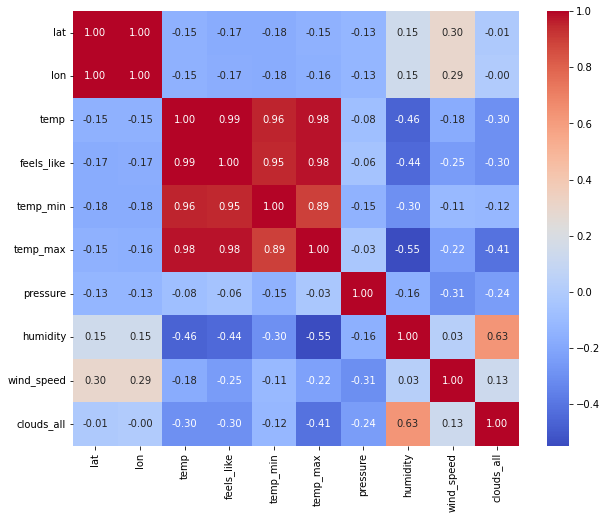

In [12]:
# Heatmapa korelacji
plt.figure(figsize=(10, 8))
sns.heatmap(df_weather_db.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

1. **Silna korelacja między wskaźnikami temperatury**: Widoczna jest bardzo wysoka korelacja między temp, feels_like, temp_min i temp_max, co jest zrozumiałe, ponieważ wszystkie te zmienne odnoszą się do temperatury. Wskaźniki te prawdopodobnie odnoszą się do tych samych zjawisk termicznych każdego dnia, stąd ich wartości zmieniają się razem w podobny sposób.

2. **Niskie korelacje z szerokością i długością geograficzną**: Zmienne lat (szerokość geograficzna) i lon (długość geograficzna) mają niskie wartości korelacji z innymi zmiennymi. Oznacza to, że te konkretne lokalizacje geograficzne nie mają silnego bezpośredniego związku z mierzonymi parametrami pogodowymi. Może to jednak oznaczać, że lokalizacja nie była głównym czynnikiem różnic w tych danych, lub że dane obejmują niewielki zakres geograficzny, gdzie warunki pogodowe są dość jednolite.

3. **Korelacja między humidity (wilgotnością) a temperaturą**: Istnieje negatywna korelacja między wilgotnością a wskaźnikami temperatury, co może wskazywać, że w dni cieplejsze powietrze jest mniej wilgotne lub na odwrót, co jest zgodne z ogólną wiedzą meteorologiczną.

4. **Słaba korelacja clouds_all z innymi zmiennymi**: Zmienna clouds_all, która mierzy poziom zachmurzenia, nie wykazuje silnych korelacji z większością innych zmiennych, co sugeruje, że stopień zachmurzenia może być niezależny od innych mierzonych warunków, jak temperatura czy wilgotność. Dla produkcji energii słonecznej, ta zmienna może być szczególnie ważna, ponieważ duża ilość chmur zwykle zmniejsza ilość docierającego do paneli światła słonecznego.

5. **Pozostałe zależności**: Są one generalnie słabe lub umiarkowane, co wskazuje, że nie ma innych silnych bezpośrednich zależności między tymi zmiennymi w danych, które podałeś.

**Wnisoki**:Te informacje mogą być pomocne w decydowaniu, które zmienne uwzględnić w modelowaniu produkcji energii fotowoltaicznej. Na przykład, można skupić się na badaniu wpływu zachmurzenia i temperatury, ponieważ mogą one mieć największy wpływ na wydajność paneli fotowoltaicznych.

### Analiza danych dla poszczególnych lokalizacji

In [13]:
# Sprawdzamy unikalne lokalizacje
unique_locations = df_weather_db['city_name'].unique()
unique_locations

array(['Baden_Baden', 'Bozanska', 'Walcz_Drugi'], dtype=object)

In [14]:
# Sprawdzamy, czy kolumna 'date' jest już typu datetime, jeśli nie, konwertujemy ją
if df_weather_db['date'].dtype != 'datetime64[ns]':
    df_weather_db['date'] = pd.to_datetime(df_weather_db['date'])

In [15]:
# Funkcja do tworzenia wykresów dla każdej lokalizacji
def create_plots_for_locations(df, locations):
    for location in locations:
        # Filtrowanie danych dla danej lokalizacji
        data_loc = df[df['city_name'] == location]

        # Histogram temperatury
        plt.figure(figsize=(10, 6))
        sns.histplot(data_loc['temp'], bins=30, kde=True)
        plt.title(f'Histogram temperatury dla {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Temperatura [°C]')  # Etykieta osi X
        plt.ylabel('Liczba obserwacji')  # Etykieta osi Y
        plt.show()  # Wyświetlenie wykresu

        # Wykres pudełkowy temperatury
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=data_loc['temp'])
        plt.title(f'Wykres pudełkowy temperatury dla {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Temperatura [°C]')  # Etykieta osi X
        plt.show()  # Wyświetlenie wykresu

        # Wykres czasowy temperatury
        plt.figure(figsize=(14, 7))
        sns.lineplot(x='date', y='temp', data=data_loc)
        plt.title(f'Wykres czasowy temperatury dla {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Data')  # Etykieta osi X
        plt.ylabel('Temperatura [°C]')  # Etykieta osi Y
        plt.xticks(rotation=45)  # Rotacja etykiet na osi X dla lepszej czytelności
        plt.tight_layout()  # Aby upewnić się, że etykiety nie są obcięte
        plt.show()  # Wyświetlenie wykresu


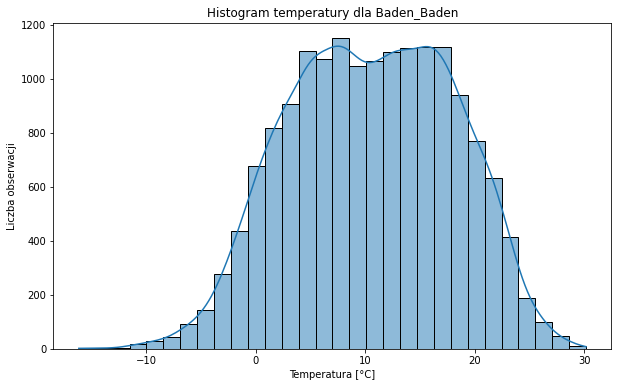

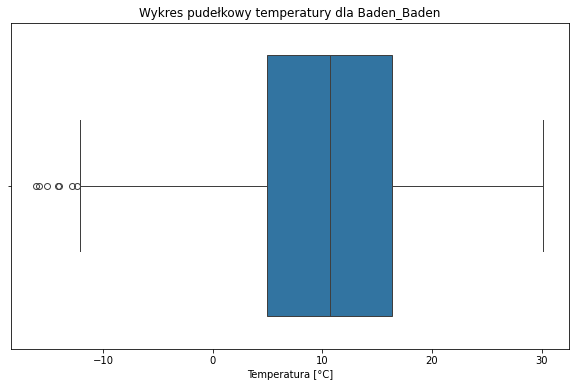

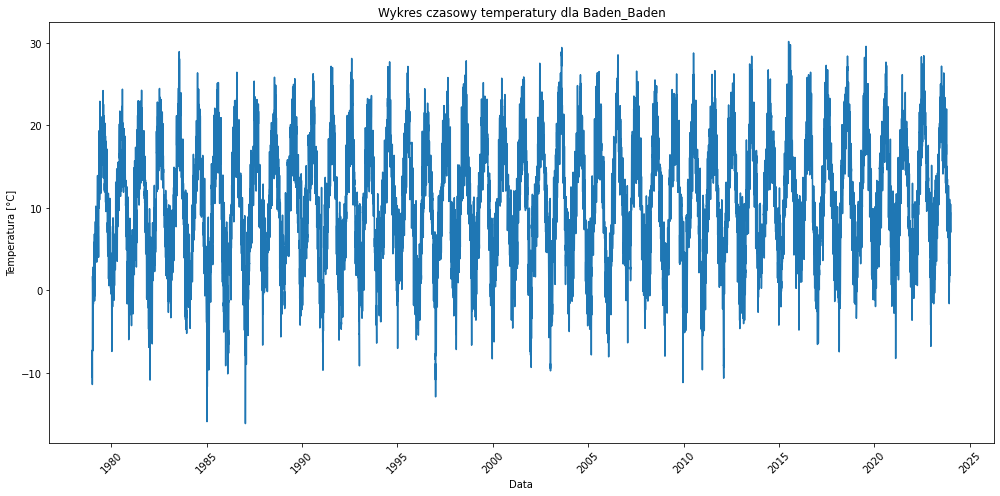

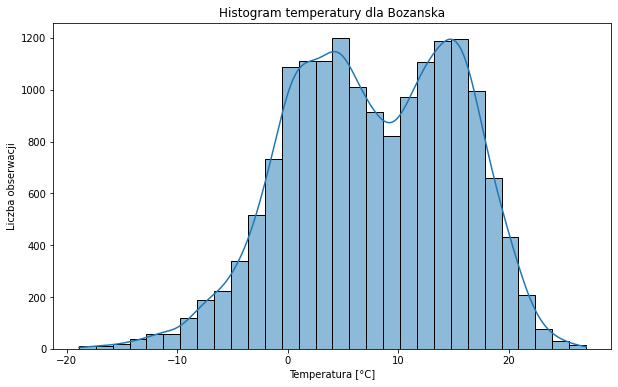

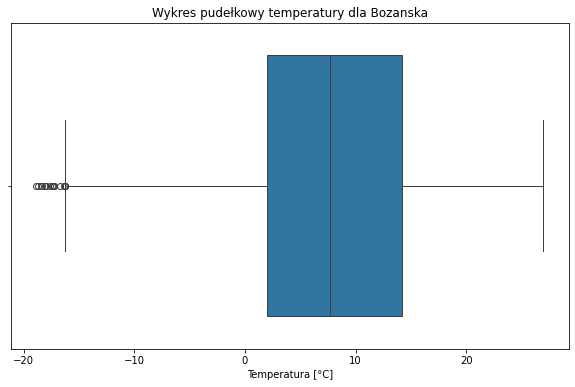

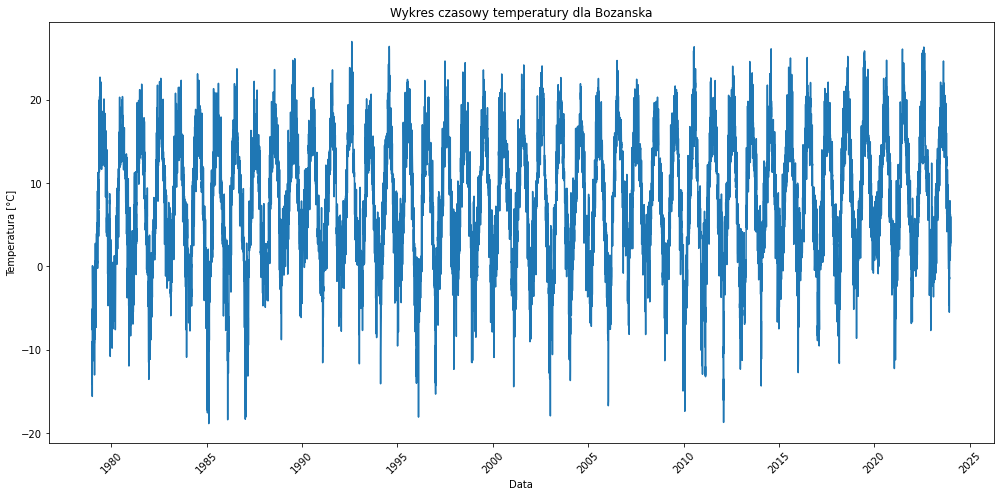

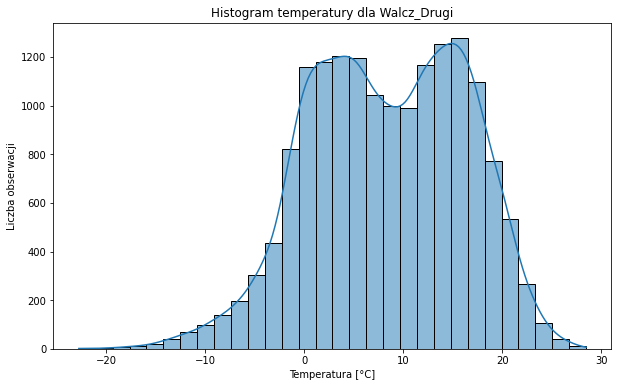

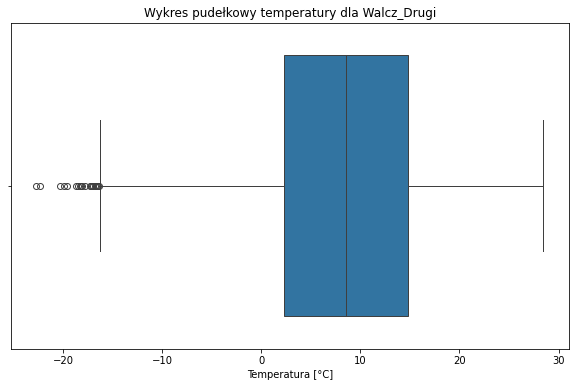

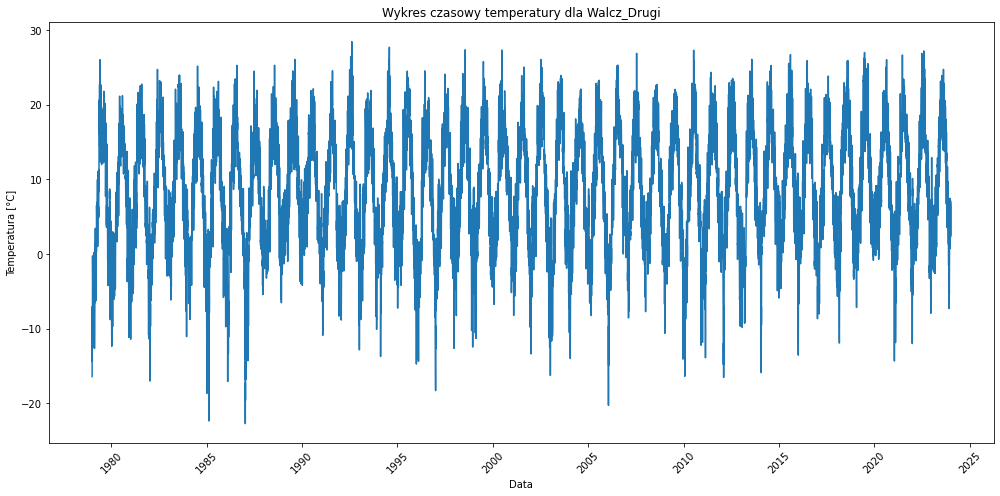

In [16]:
# Wywołanie funkcji dla unikalnych lokalizacji
create_plots_for_locations(df_weather_db, unique_locations)

## Baden-Baden:
- Histogram Temperatury: Występuje wyraźny, niemal symetryczny rozkład z szczytem w okolicach 10°C, sugerujący umiarkowane temperatury.
- Wykres Pudełkowy: Mediana temperatury znajduje się w okolicach 10°C, z kilkoma wartościami odstającymi po obu stronach zakresu.
- Wykres Czasowy: Widać wyraźną sezonowość z oscylacjami temperatur w ciągu roku, z typowym wzrostem w okresie letnim i spadkiem w zimowym.

## Bozańska:
- Histogram Temperatury: Podobnie jak w Baden-Baden, rozkład jest niemal symetryczny, ale z bardziej widocznymi bimodalnymi cechami, co może wskazywać na zróżnicowane warunki klimatyczne w ciągu roku.
- Wykres Pudełkowy: Wykres pokazuje większą ilość wartości odstających w porównaniu z Baden-Baden, co może wskazywać na bardziej ekstremalne warunki temperaturowe.
- Wykres Czasowy: Podobnie jak w Baden-Baden, widać sezonowe wahania, ale z większymi amplitudami temperatur.

## Walcz Drugi:
- Histogram Temperatury: Rozkład temperatury wykazuje również symetrię z bimodalnymi cechami, które są jeszcze bardziej zaznaczone niż w Bozańska.
- Wykres Pudełkowy: Podobne charakterystyki do Bozańska, z kilkoma ekstremalnymi wartościami odstającymi.
- Wykres Czasowy: Wahania temperatur są wyraźne, z sezonowymi wzrostami i spadkami, podobnie jak w pozostałych lokalizacjach.

## Podsumowanie:
Dane z tych trzech lokalizacji pokazują charakterystyczną sezonowość z oscylacjami temperatur w ciągu roku. Rozkłady temperatur pokazują umiarkowane do chłodnych warunków w każdej lokalizacji, z potencjalnymi bimodalnymi cechami w rozkładach temperatur dla Bozańska i Walcz Drugi, które mogą sugerować różne wzorce pogodowe w różnych porach roku. Wartości odstające na wykresach pudełkowych wskazują na okresowe ekstremalne warunki temperaturowe, które mogą mieć wpływ na efektywność systemów fotowoltaicznych w tych regionach.

### Wnioski:

Dobrym sposobem na wizualizację i analizę danych pogodowych, które mają wpływ na wydajność paneli fotowoltaicznych, będzie skupienie się na kilku kluczowych rodzajach wykresów. Oto proponowane podejścia:

1. Wykresy rozproszenia clouds_all vs. temp
Cel: Zrozumienie, jak zachmurzenie wpływa na temperatury, co jest istotne, ponieważ temperatura może wpływać na efektywność paneli słonecznych.
Wykonanie: Stworzenie wykresu rozproszenia pokazującego relację między stopniem zachmurzenia a temperaturą dla różnych dni.
2. Wykresy słupkowe dla weather_main
Cel: Zobrazowanie, jak często występują różne typy pogody.
Wykonanie: Użycie wykresu słupkowego, który pokaże częstotliwość poszczególnych typów pogody, takich jak deszcz, słońce, śnieg, itp.
3. Analiza sezonowych trendów dla clouds_all
Cel: Zrozumienie zmienności zachmurzenia w różnych porach roku.
Wykonanie: Stworzenie wykresu linii czasu z uśrednionymi miesięcznymi wartościami clouds_all dla każdej lokalizacji.
4. Wykres kombinowany dla weather_main i temp
Cel: Zobaczenie, jak różne warunki pogodowe wpływają na temperatury w ciągu roku.
Wykonanie: Stworzenie wykresu skrzynkowego dla temperatur podzielonych według typów pogody, aby zobaczyć, które warunki przynoszą wyższe lub niższe temperatury.
Jeśli te propozycje Ci odpowiadają, mogę pomóc w ich implementacji. Zacznijmy od pierwszego wykresu, który pokaże zależność między zachmurzeniem a temperaturą. Czy chcesz kontynuować z tym wykresem?

Razem dla wszystkich lokalizacji z rozróżnieniem: Jeśli interesuje Cię porównanie między lokalizacjami, możemy stworzyć wykresy, które zawierają dane ze wszystkich lokalizacji, ale różnicują je na przykład kolorami czy stylami linii. Pozwoli to na szybką wizualną ocenę różnic i podobieństw w wpływie zachmurzenia na temperaturę w różnych miejscach.

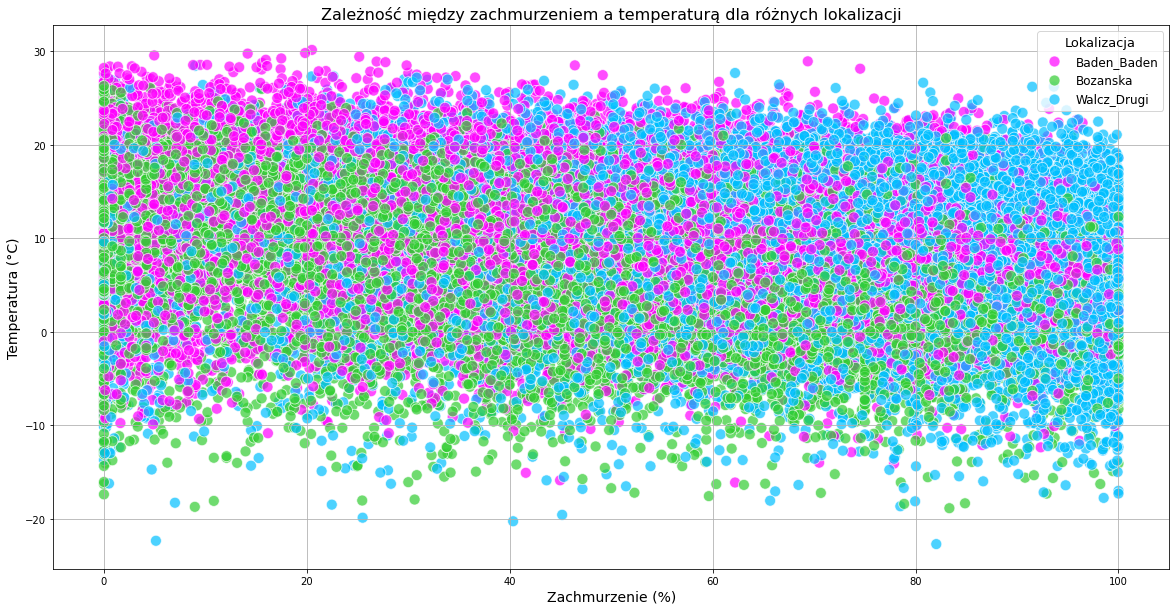

In [17]:
# Definiowanie palety kolorów dla różnych lokalizacji
# Każda lokalizacja będzie miała przypisany unikalny kolor
palette_colors = {"Baden_Baden": "magenta", "Bozanska": "limegreen", "Walcz_Drugi": "deepskyblue"}

# Tworzenie wykresu rozrzutu, który pokazuje zależność między zachmurzeniem a temperaturą dla różnych lokalizacji
plt.figure(figsize=(20, 10))
scatter_plot = sns.scatterplot(
    x='clouds_all',  # Oś X: procent zachmurzenia
    y='temp',  # Oś Y: temperatura
    hue='city_name',  # Kolory punktów zależne od lokalizacji
    data=df_weather_db,  # Dane do wykresu
    palette=palette_colors,  # Użycie zdefiniowanej palety kolorów
    s=120,  # Zwiększenie rozmiaru punktów
    alpha=0.7  # Ustawienie przezroczystości punktów
)

# Ustawienia tytułu i etykiet osi
plt.title('Zależność między zachmurzeniem a temperaturą dla różnych lokalizacji', fontsize=16)
plt.xlabel('Zachmurzenie (%)', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)

# Dodanie siatki do wykresu
plt.grid(True)

# Ustawienia legendy
plt.legend(title='Lokalizacja', title_fontsize='13', fontsize='12')

# Wyświetlenie wykresu
plt.show()


Widzimy tu jak zmieniają się temperatury w zależności od stopnia zachmurzenia dla różnych lokalizacji. Oto kilka wniosków, które możemy wyciągnąć z tej wizualizacji:

Zależność Temperatury od Zachmurzenia:
W każdej z lokalizacji rozkład temperatury wydaje się być stosunkowo równomierny w różnych poziomach zachmurzenia, co sugeruje, że zachmurzenie samo w sobie może nie mieć bezpośredniego, silnego wpływu na temperaturę. Wartości temperatury wahają się zarówno przy niskim, jak i wysokim zachmurzeniu.
### Porównanie Lokalizacji:
- Baden-Baden i Walcz Drugi pokazują podobne rozkłady temperatury, choć Walcz Drugi ma nieco większe rozproszenie temperatur przy niższym zachmurzeniu.
- Bozańska wydaje się mieć szerszy zakres temperatur w niższym zakresie zachmurzenia, co może wskazywać na różnice w lokalnym klimacie lub wpływach geograficznych na pogodę.
### Ekstremalne Warunki:
Warto zwrócić uwagę na ekstremalne wartości temperatur (bardzo niskie i bardzo wysokie), które pojawiają się niezależnie od stopnia zachmurzenia. To może sugerować, że inne czynniki, takie jak fronty atmosferyczne, wiatr, czy wilgotność, mogą mieć równie istotny wpływ na temperaturę.

### Poszczególne lokalizacje:

In [18]:
# Funkcja do tworzenia wykresów rozproszenia dla każdej lokalizacji
def create_weather_scatter_plots_for_all_locations(df, locations):
    for location in locations:
        # Filtrujemy dane dla danej lokalizacji
        location_data = df[df['city_name'] == location]

        # Wykres rozproszenia dla zachmurzenia vs. temperatura
        plt.figure(figsize=(10, 6))  # Ustawienie rozmiaru wykresu
        sns.scatterplot(x='clouds_all', y='temp', data=location_data, color='blue', alpha=0.6)  # Tworzenie wykresu rozproszenia
        plt.title(f'Zachmurzenie vs. Temperatura dla {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Zachmurzenie (%)')  # Etykieta osi X
        plt.ylabel('Temperatura (°C)')  # Etykieta osi Y
        plt.grid(True)  # Dodanie siatki do wykresu
        plt.show()  # Wyświetlenie wykresu


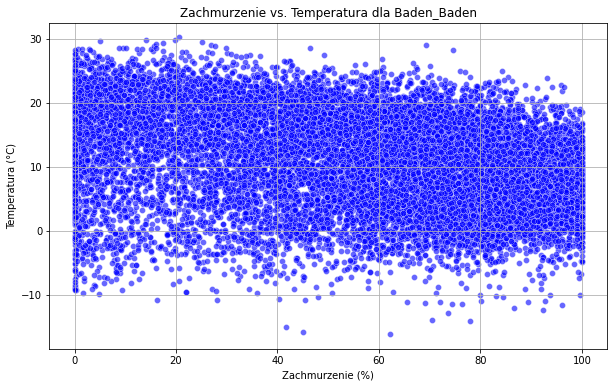

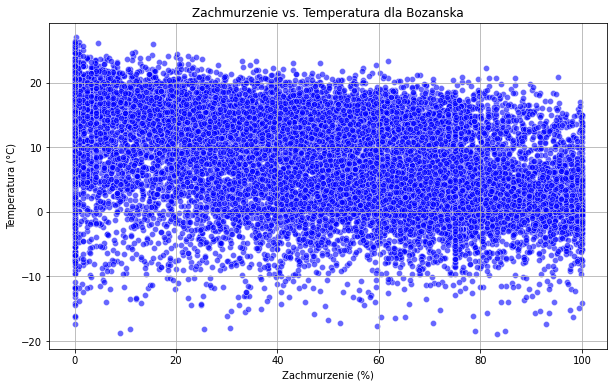

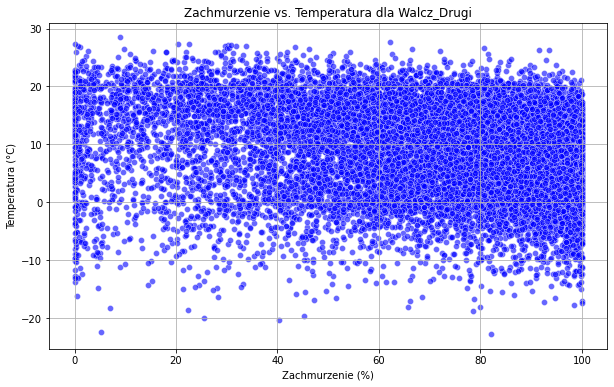

In [19]:
# Wywołanie funkcji
create_weather_scatter_plots_for_all_locations(df_weather_db, unique_locations)

Na podstawie przedstawionych wykresów rozproszenia zachmurzenia względem temperatury dla różnych lokalizacji, możemy wyciągnąć kilka wniosków dotyczących zależności między tymi dwoma zmiennymi:

### Różnorodność Rozkładów Temperatury:
W każdej lokalizacji rozkład temperatury jest szeroki, co sugeruje, że temperatura może być wpływana przez wiele czynników poza zachmurzeniem, takich jak pory roku, fronty atmosferyczne czy lokalne warunki geograficzne.
Temperatury w Bozańska wydają się osiągać niższe wartości w porównaniu z Baden-Baden i Walcz Drugi, co może być związane z różnicami w lokalnym klimacie.
### Brak Silnej Korelacji:
Nie widać wyraźnej zależności między zachmurzeniem a temperaturą na żadnym z wykresów. Dla każdego poziomu zachmurzenia obserwujemy szeroki zakres temperatur. To sugeruje, że zachmurzenie samo w sobie nie jest determinującym czynnikiem temperatury.
Wysokie temperatury mogą występować zarówno przy niskim, jak i wysokim zachmurzeniu, co może wskazywać na to, że inne czynniki, jak np. wilgotność lub ciśnienie atmosferyczne, mogą odgrywać ważniejszą rolę.
### Potencjalny Wpływ na Analizę Fotowoltaiki:
Brak silnej korelacji między zachmurzeniem a temperaturą może wskazywać na to, że dla analizy efektywności instalacji fotowoltaicznych ważniejsze będą inne dane, takie jak bezpośrednie pomiary nasłonecznienia czy długoterminowe dane meteorologiczne.
Ponieważ panele fotowoltaiczne są bardziej efektywne w chłodniejsze dni z wysokim nasłonecznieniem, brak korelacji między zachmurzeniem a niską temperaturą może sugerować, że nie można jednoznacznie przewidzieć efektywności paneli na podstawie tylko tych dwóch zmiennych.

## Przeprowadzenie Analizy pomiędzy temperaturą a wilgotnością oraz prędkością wiatru
Analizę można przeprowadzić poprzez stworzenie wykresów rozproszenia, które zobrazują zależności pomiędzy temperaturą a wilgotnością oraz prędkością wiatru dla każdej lokalizacji. Możemy także policzyć współczynniki korelacji, aby zobaczyć, jak silnie te zmienne są powiązane.

In [20]:
# Funkcja do analizy zależności między wilgotnością, prędkością wiatru a temperaturą dla każdej lokalizacji
def analyze_humidity_and_wind(df, locations):
    for location in locations:
        # Filtrowanie danych dla danej lokalizacji
        data_loc = df[df['city_name'] == location]
        
        # Wilgotność vs. Temperatura
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='humidity', y='temp', data=data_loc)
        plt.title(f'Wilgotność vs. Temperatura dla {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Wilgotność (%)')  # Etykieta osi X
        plt.ylabel('Temperatura (°C)')  # Etykieta osi Y
        plt.show()  # Wyświetlenie wykresu
        
        # Prędkość wiatru vs. Temperatura
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='wind_speed', y='temp', data=data_loc)
        plt.title(f'Prędkość Wiatru vs. Temperatura dla {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Prędkość Wiatru (m/s)')  # Etykieta osi X
        plt.ylabel('Temperatura (°C)')  # Etykieta osi Y
        plt.show()  # Wyświetlenie wykresu


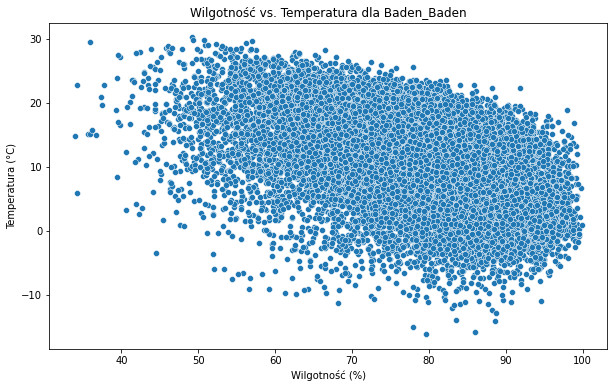

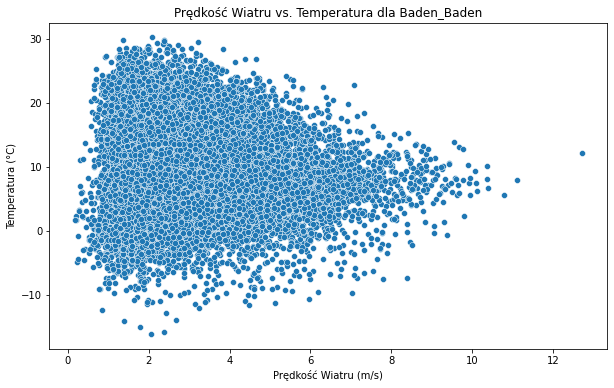

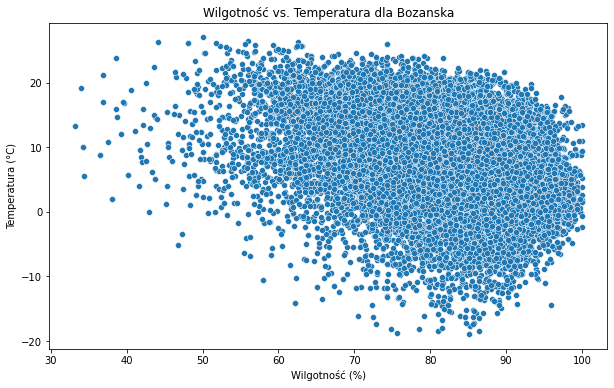

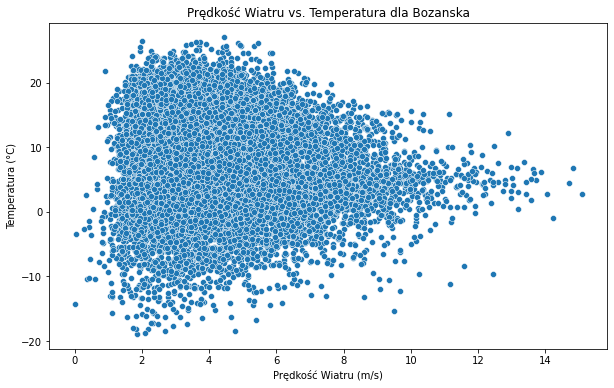

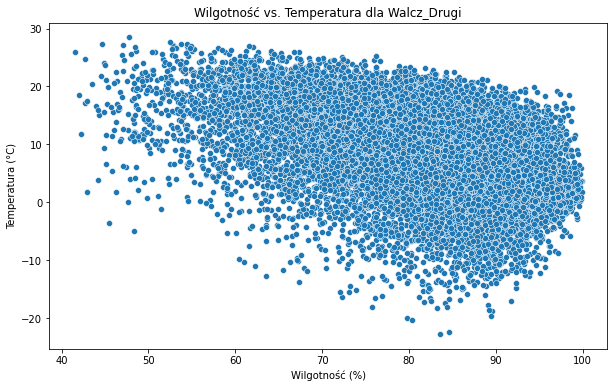

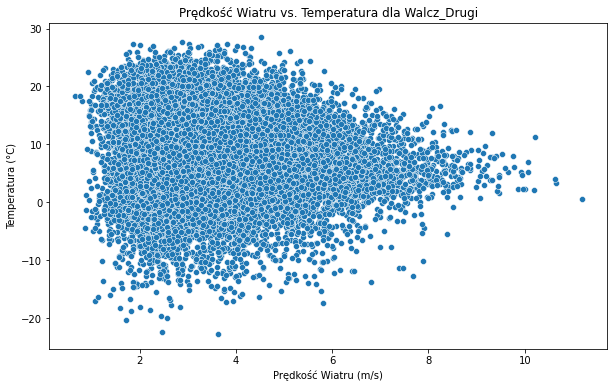

In [21]:
# Wywołanie funkcji
analyze_humidity_and_wind(df_weather_db, unique_locations)

Z przeprowadzonej analizy wynika kilka kluczowych wniosków dotyczących zależności pomiędzy warunkami pogodowymi a temperaturą dla trzech badanych lokalizacji:

### Wilgotność vs. Temperatura:
Wykresy dla wszystkich lokalizacji pokazują, że z większą wilgotnością powietrza generalnie wiąże się niższa temperatura. Jest to szczególnie widoczne w ekstremalnych warunkach wilgotności powyżej 80%, gdzie temperatury często spadają poniżej zera.
Maksymalne temperatury zazwyczaj występują przy umiarkowanej wilgotności, sugerując, że nadmierna wilgotność może ograniczać wzrost temperatur.
### Prędkość wiatru vs. Temperatura:
Z wykresów można zauważyć, że przy niższych temperaturach często występuje większa prędkość wiatru. To może wskazywać na chłodniejsze, wietrzne dni, szczególnie w zimowych miesiącach.
W okresach letnich, gdy temperatury są wyższe, prędkość wiatru jest zazwyczaj mniejsza, co jest zgodne z letnimi warunkami pogodowymi charakteryzującymi się mniejszą zmiennością wiatru.


Łączna Funkcja Analizy Pogodowej

In [22]:
# Funkcja do kompleksowej analizy danych pogodowych dla każdej lokalizacji
def comprehensive_weather_analysis(df, locations):
    for location in locations:
        # Tworzymy kopię danych dla danej lokalizacji, aby uniknąć ostrzeżenia
        data_loc = df[df['city_name'] == location].copy()
        
        # Dodajemy kolumnę 'month' do DataFrame
        data_loc['month'] = pd.to_datetime(data_loc['date']).dt.month
        
        # Wizualizacje dla różnych warunków pogodowych
        plt.figure(figsize=(14, 7))
        sns.scatterplot(x='date', y='temp', hue='weather_main', data=data_loc, palette='coolwarm', legend='full')
        plt.title(f'Temperatura w zależności od warunków pogodowych dla {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Data')  # Etykieta osi X
        plt.ylabel('Temperatura (°C)')  # Etykieta osi Y
        plt.xticks(rotation=45)  # Rotacja etykiet na osi X dla lepszej czytelności
        plt.tight_layout()  # Aby upewnić się, że etykiety nie są obcięte
        plt.show()  # Wyświetlenie wykresu

        # Wilgotność vs. Temperatura z podziałem na warunki pogodowe
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='humidity', y='temp', hue='weather_main', data=data_loc, palette='viridis', alpha=0.6)
        plt.title(f'Wilgotność vs. Temperatura dla różnych warunków pogodowych w {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Wilgotność (%)')  # Etykieta osi X
        plt.ylabel('Temperatura (°C)')  # Etykieta osi Y
        plt.grid(True)  # Dodanie siatki do wykresu
        plt.show()  # Wyświetlenie wykresu

        # Prędkość wiatru vs. Temperatura z podziałem na warunki pogodowe
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='wind_speed', y='temp', hue='weather_main', data=data_loc, palette='viridis', alpha=0.6)
        plt.title(f'Prędkość Wiatru vs. Temperatura dla różnych warunków pogodowych w {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Prędkość wiatru (m/s)')  # Etykieta osi X
        plt.ylabel('Temperatura (°C)')  # Etykieta osi Y
        plt.grid(True)  # Dodanie siatki do wykresu
        plt.show()  # Wyświetlenie wykresu

        # Analiza sezonowa - średnia temperatura każdego miesiąca
        monthly_avg = data_loc.groupby('month')['temp'].mean()  # Grupowanie danych według miesiąca i obliczenie średniej temperatury
        monthly_avg.plot(kind='bar', color='skyblue')  # Tworzenie wykresu słupkowego dla średniej temperatury
        plt.title(f'Średnia miesięczna temperatura dla {location}')  # Tytuł wykresu z nazwą lokalizacji
        plt.xlabel('Miesiąc')  # Etykieta osi X
        plt.ylabel('Średnia temperatura (°C)')  # Etykieta osi Y
        plt.xticks(rotation=0)  # Ustawienie etykiet osi X bez rotacji
        plt.show()  # Wyświetlenie wykresu


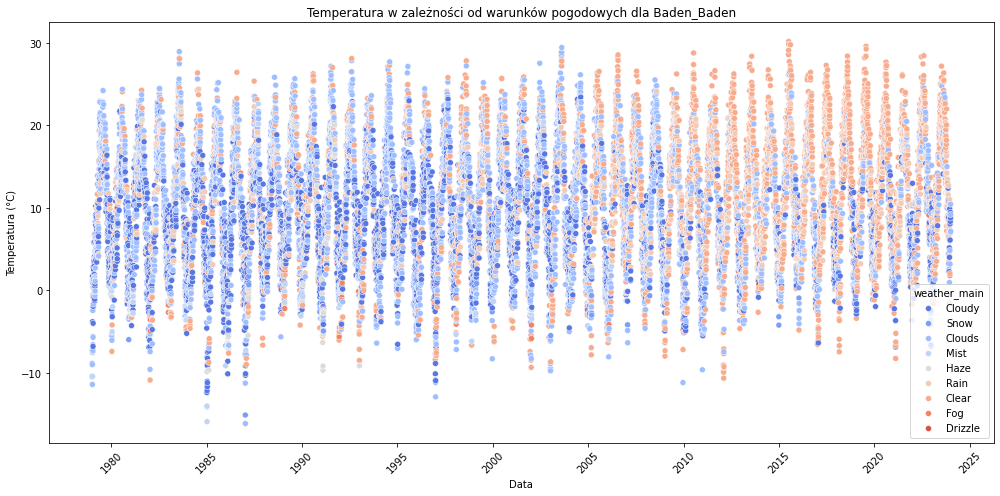

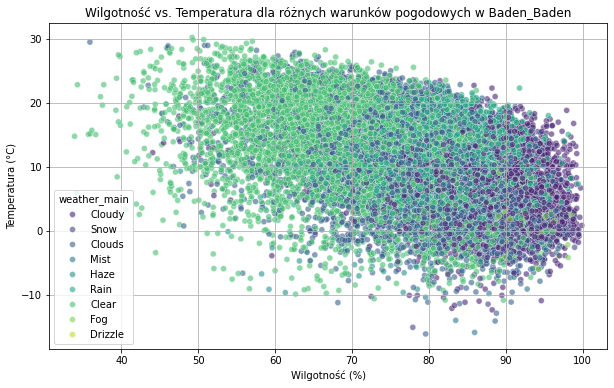

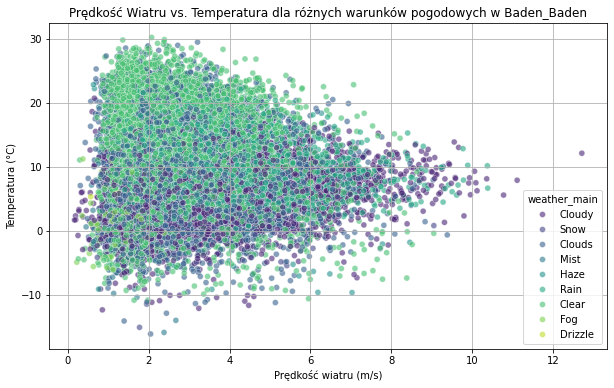

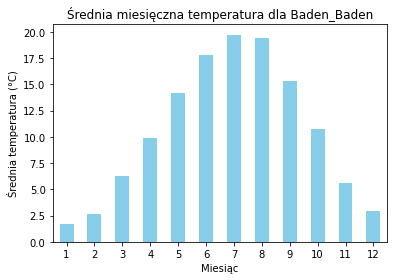

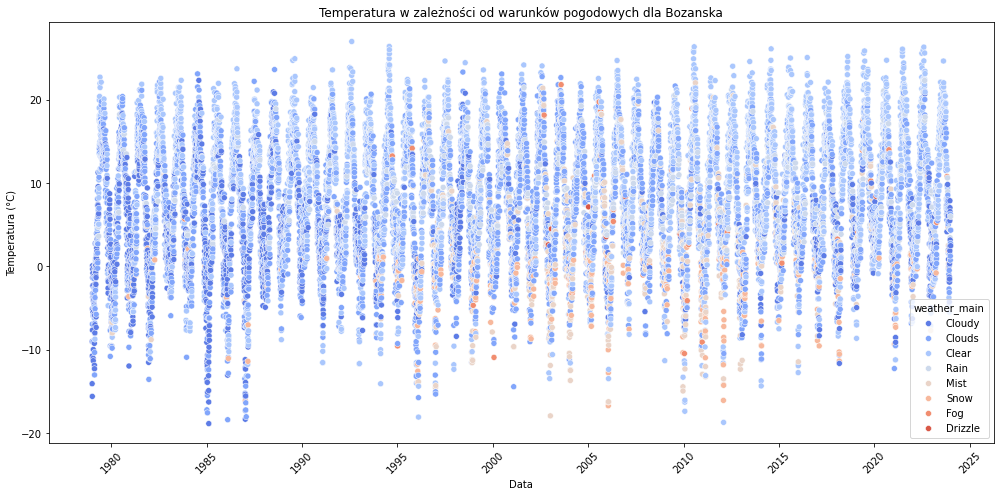

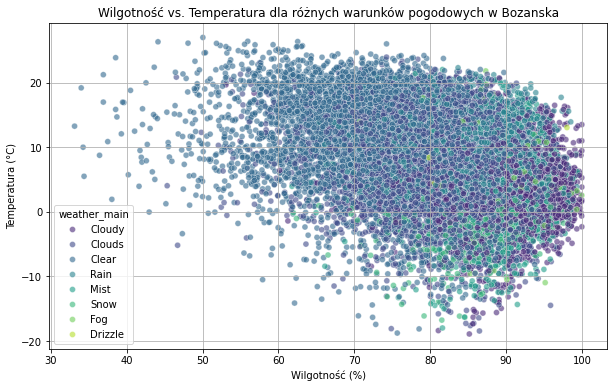

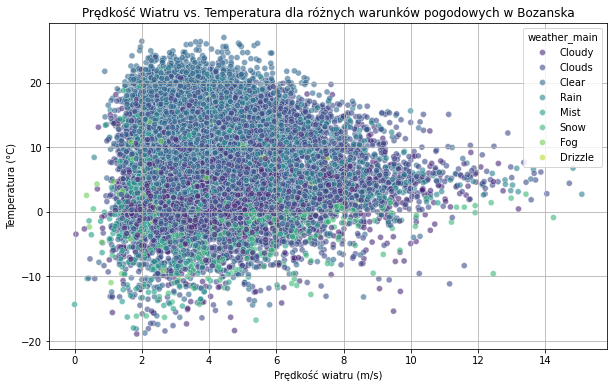

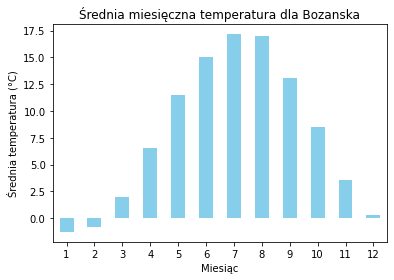

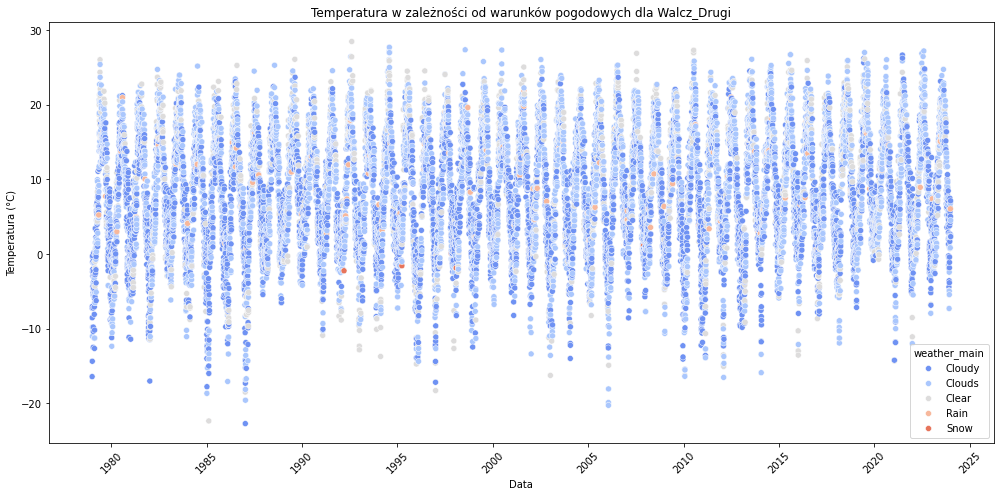

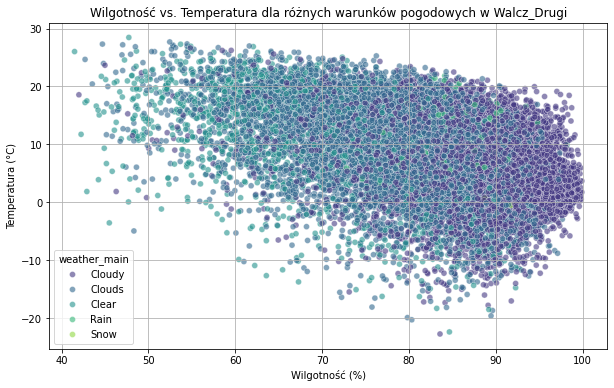

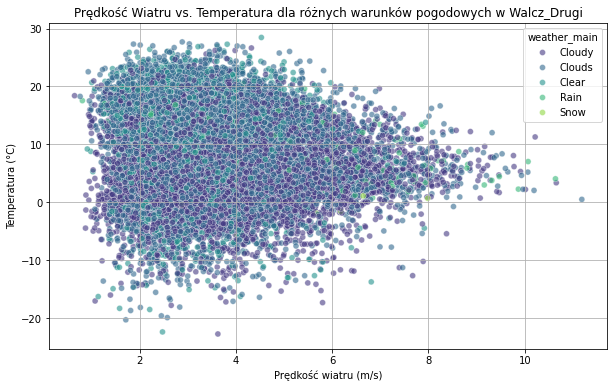

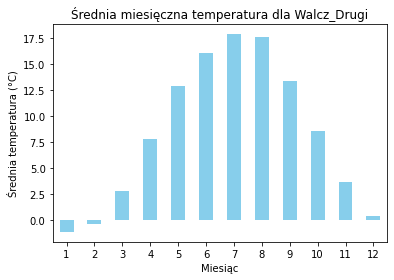

In [23]:
# Wywołanie funkcji
comprehensive_weather_analysis(df_weather_db, unique_locations)

Analiza różnorodnych wykresów przedstawiających dane historyczne z różnych lokalizacji i z różnych perspektyw daje nam kilka kluczowych wniosków:

### Zachmurzenie vs. Temperatura:
Wyraźnie widać, że większe zachmurzenie często wiąże się z niższymi temperaturami, co jest widoczne w skupieniu niższych temperatur przy wyższym poziomie zachmurzenia. To może sugerować, że dni słoneczne są zazwyczaj cieplejsze.
### Wilgotność vs. Temperatura:
Rozkład temperatur względem wilgotności pokazuje, że bardzo wysokie i bardzo niskie temperatury mogą występować przy różnych poziomach wilgotności, ale generalnie umiarkowana temperatura ma tendencję do występowania przy wyższej wilgotności.
### Prędkość wiatru vs. Temperatura:
Wykresy prędkości wiatru względem temperatury pokazują mniej wyraźną zależność, ale można zauważyć, że wyższe prędkości wiatru mogą pojawiać się zarówno przy niskich, jak i wysokich temperaturach, co może sugerować wpływ frontów atmosferycznych.
### Temperatura w zależności od warunków pogodowych:
Wykresy pokazują, że dni z określonymi warunkami pogodowymi, takimi jak śnieg czy mgła, zazwyczaj mają niższą temperaturę, co jest zgodne z oczekiwaniami. Dni słoneczne i bezchmurne wykazują wyższe temperatury, co ma kluczowe znaczenie dla modelowania produkcji energii słonecznej.
### Średnia miesięczna temperatura:
Wszystkie trzy lokalizacje pokazują wyraźny wzrost temperatury w miesiącach letnich i spadek w miesiącach zimowych, co jest typowe dla klimatu umiarkowanego. Najcieplejsze miesiące to zwykle lipiec i sierpień, a najzimniejsze - grudzień i styczeń.
Te obserwacje są bardzo istotne przy rozważaniu instalacji paneli fotowoltaicznych i analizie ich opłacalności, gdyż różnice w temperaturze, nasłonecznieniu oraz innych warunkach pogodowych bezpośrednio wpływają na wydajność i produkcję energii. Kolejne kroki mogą obejmować zintegrowanie tych danych z danymi o nasłonecznieniu oraz z potencjalnymi danymi o lokalnych instalacjach fotowoltaicznych, aby dokładniej przewidzieć opłacalność projektu w różnych lokalizacjach i porach roku.







wykres liniowy przedstawiający średnią temperaturę każdego miesiąca dla wszystkich lokalizacji nałożonych na siebie

In [24]:
# Funkcja do tworzenia wykresu średniej miesięcznej temperatury dla różnych lokalizacji
def plot_average_monthly_temperature(df, locations):
    plt.figure(figsize=(14, 7))
    
    for location in locations:
        # Filtrujemy dane dla danej lokalizacji i tworzymy kopię
        location_data = df[df['city_name'] == location].copy()
        location_data['month'] = pd.to_datetime(location_data['date']).dt.month
        
        # Obliczamy średnią temperaturę dla każdego miesiąca
        monthly_avg = location_data.groupby('month')['temp'].mean()
        
        # Rysujemy wykres liniowy średniej miesięcznej temperatury
        plt.plot(monthly_avg.index, monthly_avg.values, label=location, marker='o')
    
    # Dodajemy oznaczenia do wykresu
    plt.title('Średnia miesięczna temperatura dla różnych lokalizacji')  # Tytuł wykresu
    plt.xlabel('Miesiąc')  # Etykieta osi X
    plt.ylabel('Średnia temperatura (°C)')  # Etykieta osi Y
    plt.legend(title='Lokalizacja')  # Legenda z tytułem
    plt.xticks(range(1, 13), ['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze', 'Lip', 'Sie', 'Wrz', 'Paź', 'Lis', 'Gru'])  # Etykiety osi X dla miesięcy
    plt.grid(True)  # Dodanie siatki do wykresu
    plt.show()  # Wyświetlenie wykresu


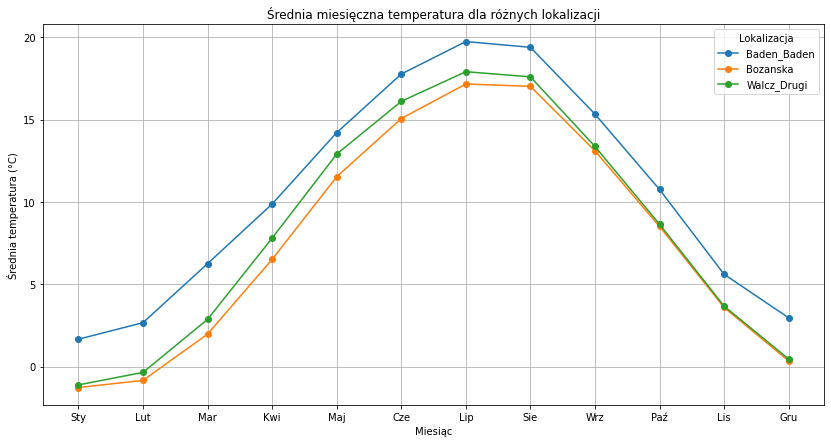

In [25]:
# Wywołanie funkcji
plot_average_monthly_temperature(df_weather_db, unique_locations)

Funkcja do Średniej Miesięcznej dla Zachmurzenia, Wilgotności i Prędkości Wiatru

Co Ta Funkcja Osiąga?
Analiza Sezonowa dla Różnych Warunków: Wykresy te umożliwiają analizę sezonowych zmian w zachmurzeniu, wilgotności i prędkości wiatru dla różnych lokalizacji. Taka analiza jest istotna, ponieważ może wpływać na produkcję energii słonecznej i decyzje dotyczące lokalizacji instalacji.
Porównanie między Lokalizacjami: Porównanie warunków pogodowych między różnymi lokalizacjami pomoże zidentyfikować obszary z korzystniejszymi warunkami dla energii słonecznej.

In [26]:
# Funkcja do tworzenia wykresów średnich miesięcznych warunków pogodowych dla różnych lokalizacji
def plot_average_monthly_weather_conditions(df, locations):
    # Definiujemy atrybuty pogodowe, które będą analizowane
    weather_attributes = ['clouds_all', 'humidity', 'wind_speed']
    # Etykiety dla atrybutów pogodowych do umieszczenia na wykresach
    attribute_labels = {
        'clouds_all': 'Zachmurzenie (%)',
        'humidity': 'Wilgotność (%)',
        'wind_speed': 'Prędkość wiatru (m/s)'
    }

    # Iteracja po każdym atrybucie pogodowym
    for attribute in weather_attributes:
        plt.figure(figsize=(20, 10))

        for location in locations:
            # Filtrujemy dane dla danej lokalizacji i tworzymy kopię
            location_data = df[df['city_name'] == location].copy()
            # Dodajemy kolumnę z miesiącem
            location_data['month'] = pd.to_datetime(location_data['date']).dt.month
            
            # Obliczamy średnią dla atrybutu dla każdego miesiąca
            monthly_avg = location_data.groupby('month')[attribute].mean()
            
            # Rysujemy wykres liniowy
            plt.plot(monthly_avg.index, monthly_avg.values, label=location, marker='o')
        
        # Dodajemy oznaczenia do wykresu
        plt.title(f'Średnia miesięczna {attribute_labels[attribute]} dla różnych lokalizacji')  # Tytuł wykresu
        plt.xlabel('Miesiąc')  # Etykieta osi X
        plt.ylabel(attribute_labels[attribute])  # Etykieta osi Y
        plt.legend(title='Lokalizacja')  # Legenda z tytułem
        plt.xticks(range(1, 13), ['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze', 'Lip', 'Sie', 'Wrz', 'Paź', 'Lis', 'Gru'])  # Etykiety dla osi X
        plt.grid(True)  # Dodanie siatki do wykresu
        plt.ylim(bottom=0)  # Ustawienie dolnej granicy osi Y na 0
        plt.show()  # Wyświetlenie wykresu


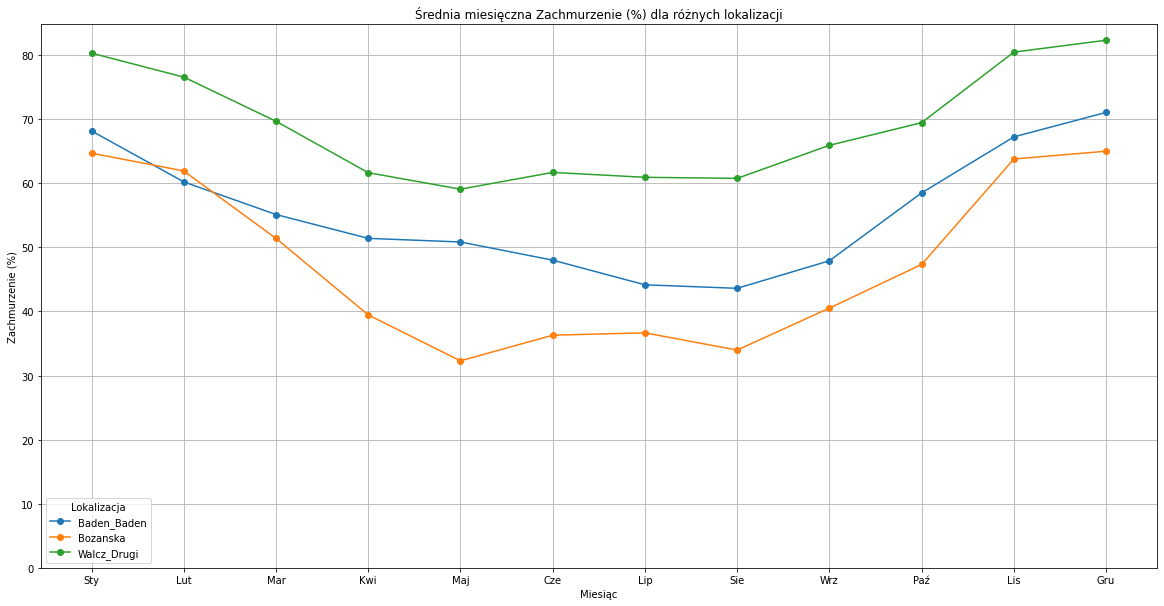

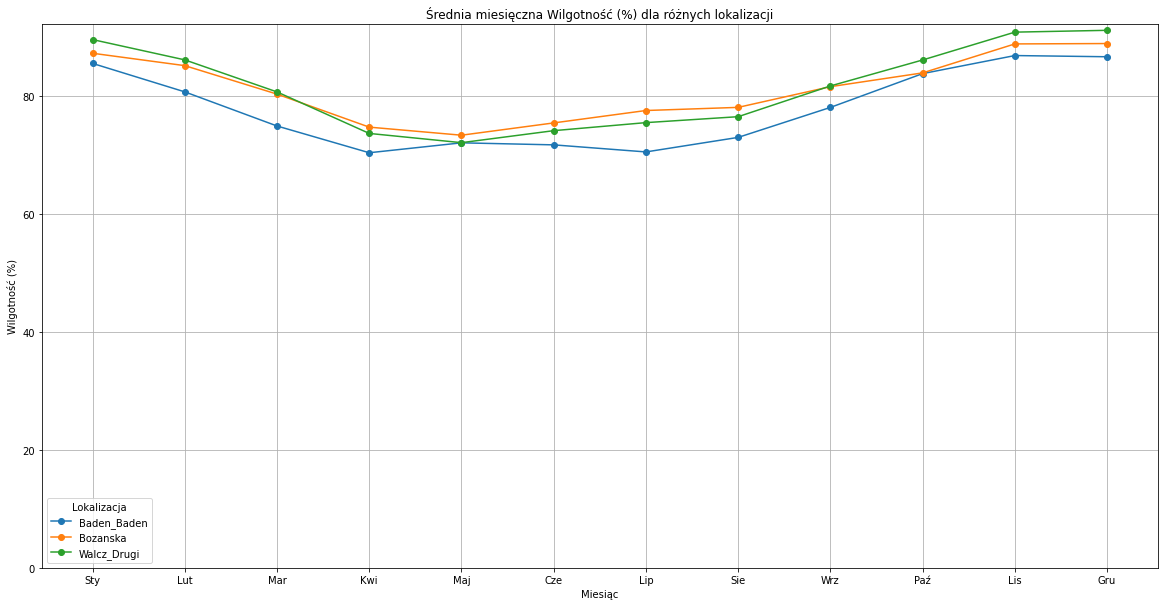

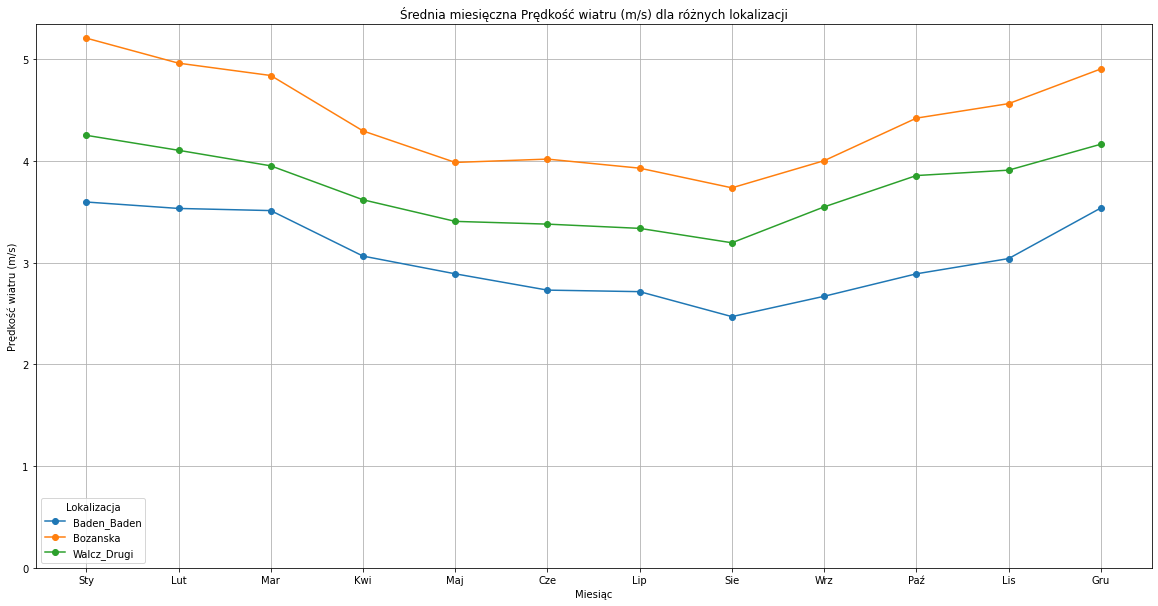

In [27]:
# Wywołanie funkcji
plot_average_monthly_weather_conditions(df_weather_db, unique_locations)

Z przedstawionych wykresów wynikają ciekawe wnioski odnośnie sezonowości oraz różnic regionalnych w pogodzie dla różnych lokalizacji:

### Zachmurzenie:
W Baden-Baden zachmurzenie jest stosunkowo stałe przez cały rok z nieznacznymi wzrostami w miesiącach letnich.
W Bożańska i Walcz Drugi również obserwujemy względną stałość zachmurzenia, z nieco większymi wahaniami w okresach przejściowych (wiosna/jesień).
### Wilgotność:
Wilgotność wykazuje wyraźne wzrosty w okresach zimowych dla wszystkich lokalizacji, co jest typowe dla klimatów umiarkowanych, gdzie zimą powietrze może utrzymywać mniej pary wodnej, co sprawia, że przy niskich temperaturach powietrze wydaje się wilgotniejsze.
Zauważalne jest, że wszystkie trzy lokalizacje mają podobne profile wilgotności, co może sugerować zbliżone warunki klimatyczne w tych obszarach.
### Prędkość wiatru:
Baden-Baden i Bożańska pokazują zwiększoną prędkość wiatru w okresie zimowym, co może być spowodowane większą różnicą ciśnień atmosferycznych w tym okresie.
W Walcz Drugi prędkość wiatru jest najniższa w miesiącach letnich, co może być związane z lokalnymi warunkami geograficznymi lub mniejszą aktywnością frontów atmosferycznych latem.

#### Zalecenia:

Dalsza analiza: Te dane mogą być wykorzystane do dalszej analizy efektywności instalacji fotowoltaicznych, ponieważ intensywność światła słonecznego i jego dostępność są ściśle związane z zachmurzeniem.

Planowanie energetyczne: Informacje o prędkości wiatru mogą być przydatne w planowaniu instalacji turbin wiatrowych, zwłaszcza w Baden-Baden i Bożańska, gdzie obserwujemy wyższe prędkości wiatru.

Adaptacja do sezonowych zmian: Wiedza o sezonowych zmianach w wilgotności i zachmurzeniu może pomóc w planowaniu działań mających na celu optymalizację wykorzystania energii, zwłaszcza w miesiącach zimowych, gdy zapotrzebowanie na ogrzewanie jest wyższe.

#### Oszacowanie wpływu warunków pogodowych na produkcję energii.

In [28]:
# Wyświetlenie pierwszych pięciu wierszy DataFrame zawierającego dane pogodowe
df_weather_db.head()

date    city_name        lat        lon       temp  feels_like  \
0 1979-01-01  Baden_Baden  48.765640   8.228524 -10.442083  -16.532917   
1 1979-01-01     Bozanska  54.473028  18.302179 -14.100000  -20.617500   
2 1979-01-01  Walcz_Drugi  53.257039  16.521203 -16.437083  -23.322500   
3 1979-01-02  Baden_Baden  48.765640   8.228524  -8.856667  -14.874167   
4 1979-01-02     Bozanska  54.473028  18.302179  -9.037917  -15.179167   

   temp_min  temp_max     pressure   humidity  wind_speed  clouds_all  \
0    -16.18      3.02  1013.666667  81.916667    3.681667   84.500000   
1    -19.14     -9.46  1002.416667  82.000000    6.157917  100.000000   
2    -21.26     -9.57  1003.708333  82.416667    3.682083   94.791667   
3    -15.82     -3.96  1024.250000  84.208333    4.524583   71.708333   
4    -14.14     -7.40  1004.791667  85.375000    4.449583   99.541667   

  weather_main  
0       Cloudy  
1       Cloudy  
2       Cloudy  
3         Snow  
4       Cloudy

1. Szacowanie nasłonecznienia: Ustalimy wartości nasłonecznienia na podstawie clouds_all i weather_main. Załóżmy, że dni z mniejszym zachmurzeniem (np. poniżej 20%) i warunki "Clear" oznaczają pełne nasłonecznienie, a inne warunki pogodowe będą miały niższe wartości nasłonecznienia.

2. Modyfikator temperatury: Efektywność paneli fotowoltaicznych zazwyczaj spada przy bardzo wysokich temperaturach (powyżej 25°C). Możemy użyć prostej funkcji, która obniża efektywność w takich warunkach.

3. Modyfikator wilgotności: Panele fotowoltaiczne mogą być mniej efektywne przy bardzo niskiej lub bardzo wysokiej wilgotności. Możemy stworzyć funkcję, która uwzględni te zmienne.

### KAWALEK KODU DLA PREZENTACJI

bazujac na litraturze fachowej:

nstalacja fotowoltaiczna o mocy 1 kWp można dostarczać w ciągu roku ok. 900-980 kWh energii elektrycznej.
Instalacja fotowoltaiczna o mocy 5 kWp wytwarza rocznie ok. 4000 do 5000 kWh energii elektrycznej (w zależności od lokalizacji, skierowania i kąta nachylenia do płaszczyzny poziomej).

Dla instalacji 5 kWp roczna produkcja energii rzędu 4000 do 5000 kWh jest typowa dla większości lokalizacji w strefach o umiarkowanym nasłonecznieniu. Na przykład:

Jeżeli twoja instalacja wytwarza 4500 kWh rocznie, średnia dzienna produkcja wynosi:
S
ˊ
rednia dzienna produkcja
=
4500
 kWh
365
 dni
≈
12.33
 kWh/dzie
n
ˊ
S
ˊ
 rednia dzienna produkcja= 
365 dni
4500 kWh
​
 ≈12.33 kWh/dzie 
n
ˊ
 
Wartości, które otrzymujesz w swoich obliczeniach, powinny zbliżać się do tej liczby, jeżeli warunki są optymalne (tj. pełne nasłonecznienie, odpowiednie kąty nachylenia paneli, brak cieniowania itp.).

Sprawdzenie, czy Twoje obliczenia są zgodne z rzeczywistością, może wymagać przemyślenia założeń dotyczących estimated_irradiance. Jeśli Twoje wartości nasłonecznienia są znacznie niższe niż typowe wartości nasłonecznienia dla danej lokalizacji, możesz potrzebować skorygować sposób, w jaki obliczasz lub szacujesz to nasłonecznienie w swojej bazie danych. Może to być także kwestia metodologiczna, na przykład niewłaściwe użycie współczynnika performance_ratio lub nieuwzględnienie innych strat systemowych w modelu.

Wygląda na to, że w Twoim modelu estimated_irradiance jest określone jako współczynnik, który przyjmuje wartości od 0 do 1, reprezentujące procent maksymalnego możliwego nasłonecznienia. Natomiast w typowych modelach fotowoltaicznych, nasłonecznienie (irradiance) jest mierzone w kWh/m²/dzień i zazwyczaj przekracza wartość 1 w dni słoneczne, szczególnie w lokalizacjach o wysokim nasłonecznieniu.

Jak dostosować model
Zdefiniuj estimated_irradiance w kWh/m²/dzień: Jeśli chcesz użyć bardziej standardowego podejścia, estimated_irradiance powinien odzwierciedlać faktyczne nasłonecznienie w kWh na metr kwadratowy na dzień. Możesz przeskalować swoje obecne dane lub użyć zewnętrznych danych nasłonecznienia dla swojej lokalizacji.

Dostosowanie funkcji obliczającej nasłonecznienie:

Zamiast używać procentów, funkcja powinna zwracać wartość w kWh/m²/dzień.
Na przykład, jeśli chmury zasłaniają 40% nieba, a typowe nasłonecznienie w pełnym słońcu wynosi 5 kWh/m²/dzień, to przy takim zachmurzeniu nasłonecznienie mogłoby wynosić około 60% z 5 kWh/m², czyli 3 kWh/m².

In [29]:
# Funkcja do obliczania nasłonecznienia na podstawie zachmurzenia i pogody. Funkcja calculate_irradiance używa wartości typical_irradiance i modyfikuje ją w zależności od zachmurzenia i warunków pogodowych, aby uzyskać realistyczne szacunki dziennego nasłonecznienia.
def calculate_irradiance(row):
    clouds = row['clouds_all']
    weather = row['weather_main']
    typical_irradiance = 5  # Zakładając, że pełne nasłonecznienie daje 5 kWh/m²/dzień. Wartość typical_irradiance = 5 jest dobrze dobrana jako typowa wartość nasłonecznienia w pełnym słońcu, wyrażona w kWh/m²/dzień. Taka wartość jest realistyczna dla wielu lokalizacji w pełnym słońcu i dobrze nadaje się do obliczeń produkcji energii z instalacji fotowoltaicznej.


    # Maksymalne nasłonecznienie przy idealnie czystym niebie
    if weather == 'Clear' and clouds == 0:
        return typical_irradiance
    elif weather == 'Clear':
        if clouds < 20:
            return typical_irradiance * 0.9
        elif clouds < 40:
            return typical_irradiance * 0.75
        elif clouds < 60:
            return typical_irradiance * 0.6
        else:
            return typical_irradiance * 0.4
    elif weather == 'Cloudy':
        if clouds < 20:
            return typical_irradiance * 0.9
        elif clouds < 40:
            return typical_irradiance * 0.75
        elif clouds < 60:
            return typical_irradiance * 0.6
        else:
            return typical_irradiance * 0.4
    elif weather in ['Rain', 'Drizzle', 'Snow']:
        return typical_irradiance * 0.3
    elif weather in ['Fog', 'Mist']:
        return typical_irradiance * 0.2
    else:
        return typical_irradiance * 0.5

# Funkcja do modyfikacji efektywności na podstawie temperatury
def temperature_modifier(temp):
    if temp > 25:
        return 0.95  # Obniżenie efektywności przy wysokich temperaturach
    else:
        return 1.0  # Brak zmiany efektywności

# Funkcja do modyfikacji efektywności na podstawie wilgotności
def humidity_modifier(humidity):
    if humidity < 30 or humidity > 80:
        return 0.95  # Obniżenie efektywności przy skrajnych wartościach wilgotności
    else:
        return 1.0  # Brak zmiany efektywności

# Zastosowanie funkcji do ramki df_weather_db
df_weather_db['estimated_irradiance'] = df_weather_db.apply(calculate_irradiance, axis=1)
df_weather_db['temp_modifier'] = df_weather_db['temp'].apply(temperature_modifier)
df_weather_db['humidity_modifier'] = df_weather_db['humidity'].apply(humidity_modifier)


In [30]:
# Wyświetlenie pierwszych pięciu wierszy DataFrame zawierającego dane pogodowe
df_weather_db.head()

date    city_name        lat        lon       temp  feels_like  \
0 1979-01-01  Baden_Baden  48.765640   8.228524 -10.442083  -16.532917   
1 1979-01-01     Bozanska  54.473028  18.302179 -14.100000  -20.617500   
2 1979-01-01  Walcz_Drugi  53.257039  16.521203 -16.437083  -23.322500   
3 1979-01-02  Baden_Baden  48.765640   8.228524  -8.856667  -14.874167   
4 1979-01-02     Bozanska  54.473028  18.302179  -9.037917  -15.179167   

   temp_min  temp_max     pressure   humidity  wind_speed  clouds_all  \
0    -16.18      3.02  1013.666667  81.916667    3.681667   84.500000   
1    -19.14     -9.46  1002.416667  82.000000    6.157917  100.000000   
2    -21.26     -9.57  1003.708333  82.416667    3.682083   94.791667   
3    -15.82     -3.96  1024.250000  84.208333    4.524583   71.708333   
4    -14.14     -7.40  1004.791667  85.375000    4.449583   99.541667   

  weather_main  estimated_irradiance  temp_modifier  humidity_modifier  
0       Cloudy                   2.0            1.0               0.95  
1       Cloudy                   2.0            1.0               0.95  
2       Cloudy                   2.0            1.0               0.95  
3         Snow                   1.5            1.0               0.95  
4       Cloudy                   2.0            1.0               0.95

Na początku projektu zidentyfikowaliśmy kluczowe czynniki, które wpływają na produkcję energii z paneli fotowoltaicznych, takie jak nasłonecznienie, temperatura i wilgotność. Opracowaliśmy sposób na ich modelowanie i implementację w ramce danych, co pozwoli na dalszą analizę efektywności i opłacalności instalacji fotowoltaicznych.

Oto, co już osiągnęliśmy:

1. Szacowane nasłonecznienie (estimated_irradiance) - stworzyliśmy przybliżenie nasłonecznienia na podstawie danych o zachmurzeniu (clouds_all) i warunkach pogodowych (weather_main), co jest zgodne z wcześniejszym stwierdzeniem o braku bezpośrednich danych o nasłonecznieniu.
2. Modyfikator temperatury (temp_modifier) - uwzględnia wpływ temperatury na efektywność paneli, gdzie wyższe temperatury mogą powodować spadek wydajności, zgodnie z fizycznymi właściwościami paneli fotowoltaicznych.
3. Modyfikator wilgotności (humidity_modifier) - podobnie, skrajne wartości wilgotności mogą wpływać na efektywność paneli, co było również uwzględnione w początkowej analizie.

Kolejne kroki:
- Implementacja wzoru na produkcję energii: Teraz, gdy mamy szacunki nasłonecznienia i modyfikatory dla temperatury i wilgotności, możemy przejść do obliczenia faktycznej produkcji energii (E) z wzoru E = P × H × PR, gdzie:
- P (moc zainstalowana) może być podana przez użytkownika lub oszacowana dla typowego systemu.
- H (średnie roczne nasłonecznienie na jednostkę powierzchni) można obliczyć z naszej kolumny estimated_irradiance.
- PR (Performance Ratio) możemy przyjąć jako średni przemysłowy standard, np. 0,75 do 0,85.

Utworzymy model, który będzie uwzględniał temperaturę, wilgotność oraz nasłonecznienie (szacowane z danych pogodowych) do obliczenia potencjalnej produkcji energii. W tym celu możemy wykorzystać prosty wzór, który oszacuje redukcję wydajności paneli związanej z temperaturą i wilgotnością, a także przybliżone nasłonecznienie na podstawie danych o zachmurzeniu.

Na początek przyjmijmy pewne standardowe wartości dla mocy zainstalowanej (P) i współczynnika wydajności (Performance Ratio, PR), które będziemy mogli później dostosować:

1. Moc zainstalowana (P): Możemy założyć, że typowy system fotowoltaiczny, który analizujemy, ma moc 5 kWp. Jeśli masz inne dane lub preferencje co do wielkości systemu, daj mi znać.
2. Współczynnik wydajności (PR): Wartość PR może wahać się zwykle między 0.75 a 0.85, ale dla naszych obliczeń przyjmijmy 0.80 jako średnią wartość, co odzwierciedla umiarkowane straty systemowe i realne warunki pracy.

#### Obliczenie produkcji energii
Wykorzystamy nasze szacowane nasłonecznienie oraz modyfikatory efektywności dla temperatury i wilgotności do obliczenia potencjalnej rocznej produkcji energii. Obliczenia te będą wykonane dla każdego dnia, a następnie zsumowane, aby uzyskać roczną produkcję energii.

In [31]:
# Stałe
installed_power_kWp = 5  # Moc zainstalowana w kWp
performance_ratio = 0.80  # Współczynnik wydajności (PR)

# Obliczanie dziennej produkcji energii
df_weather_db['daily_energy_production_kWh'] = ( # tutaj powinno byc kWh/day tylko trzeba w calym kodzie poprawiac!!!!
    installed_power_kWp * 
    df_weather_db['estimated_irradiance'] *  # już w kWh/m²/dzień
    performance_ratio * 
    df_weather_db['temp_modifier'] * 
    df_weather_db['humidity_modifier']
)

In [32]:
# Sprawdzenie, jak wyglądają pierwsze kilka wierszy z nową kolumną
df_weather_db.head()

date    city_name        lat        lon       temp  feels_like  \
0 1979-01-01  Baden_Baden  48.765640   8.228524 -10.442083  -16.532917   
1 1979-01-01     Bozanska  54.473028  18.302179 -14.100000  -20.617500   
2 1979-01-01  Walcz_Drugi  53.257039  16.521203 -16.437083  -23.322500   
3 1979-01-02  Baden_Baden  48.765640   8.228524  -8.856667  -14.874167   
4 1979-01-02     Bozanska  54.473028  18.302179  -9.037917  -15.179167   

   temp_min  temp_max     pressure   humidity  wind_speed  clouds_all  \
0    -16.18      3.02  1013.666667  81.916667    3.681667   84.500000   
1    -19.14     -9.46  1002.416667  82.000000    6.157917  100.000000   
2    -21.26     -9.57  1003.708333  82.416667    3.682083   94.791667   
3    -15.82     -3.96  1024.250000  84.208333    4.524583   71.708333   
4    -14.14     -7.40  1004.791667  85.375000    4.449583   99.541667   

  weather_main  estimated_irradiance  temp_modifier  humidity_modifier  \
0       Cloudy                   2.0            1.0               0.95   
1       Cloudy                   2.0            1.0               0.95   
2       Cloudy                   2.0            1.0               0.95   
3         Snow                   1.5            1.0               0.95   
4       Cloudy                   2.0            1.0               0.95   

   daily_energy_production_kWh  
0                          7.6  
1                          7.6  
2                          7.6  
3                          5.7  
4                          7.6

### TU SKONCZYLEM **************************************************************************************

In [33]:
# Wyświetlenie unikalnych wartości w kolumnie 'weather_main' DataFrame 'df_weather_db'
df_weather_db["weather_main"].unique()

array(['Cloudy', 'Snow', 'Clouds', 'Mist', 'Haze', 'Clear', 'Rain', 'Fog',
       'Drizzle'], dtype=object)

In [34]:
# Wybór i wyświetlanie pierwszych pięciu wierszy z danymi pogodowymi, gdzie głównym stanem pogodowym jest "Clear"
df_weather_db[df_weather_db["weather_main"]=="Clear"].head()

date    city_name        lat        lon      temp  feels_like  \
121 1979-02-10     Bozanska  54.473028  18.302179 -4.844167  -11.355417   
124 1979-02-11     Bozanska  54.473028  18.302179 -6.248333  -10.862083   
160 1979-02-23     Bozanska  54.473028  18.302179 -8.757083  -13.771250   
167 1979-02-25  Walcz_Drugi  53.257039  16.521203 -4.302917   -8.830000   
176 1979-02-28  Walcz_Drugi  53.257039  16.521203 -1.005417   -5.106250   

     temp_min  temp_max     pressure   humidity  wind_speed  clouds_all  \
121     -9.84     -1.08  1002.708333  86.875000    6.069167    7.916667   
124    -13.14     -1.08  1009.958333  86.166667    3.913333   18.000000   
160    -14.56     -0.84  1026.541667  84.291667    3.346250   29.541667   
167     -9.73      0.05  1035.375000  87.750000    3.289167   26.666667   
176     -5.01      3.91  1016.041667  74.250000    3.484167   32.625000   

    weather_main  estimated_irradiance  temp_modifier  humidity_modifier  \
121        Clear                  4.50            1.0               0.95   
124        Clear                  4.50            1.0               0.95   
160        Clear                  3.75            1.0               0.95   
167        Clear                  3.75            1.0               0.95   
176        Clear                  3.75            1.0               1.00   

     daily_energy_production_kWh  
121                        17.10  
124                        17.10  
160                        14.25  
167                        14.25  
176                        15.00

### PODSUMOWANIE

Globalne analiza oraz lokalna

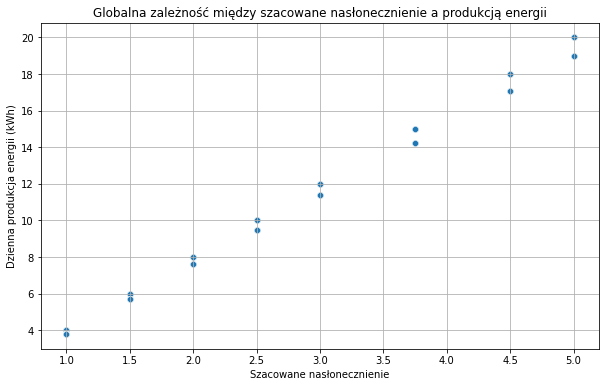

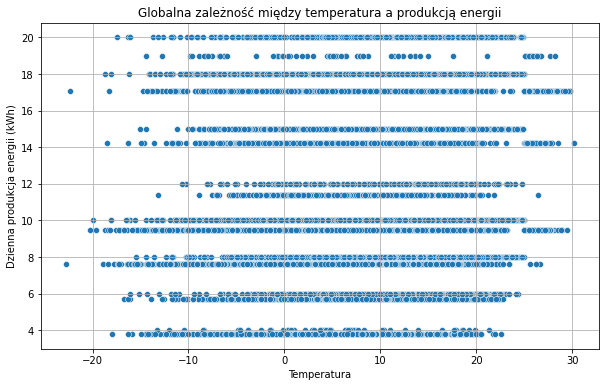

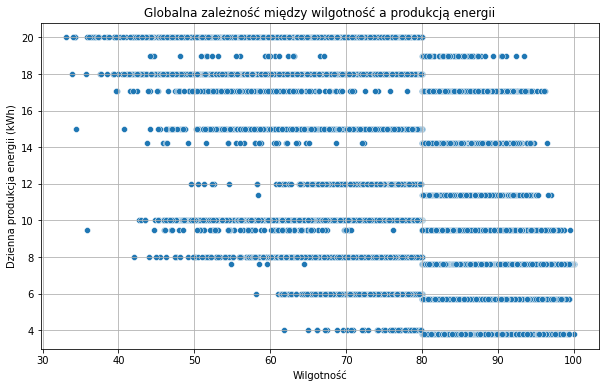

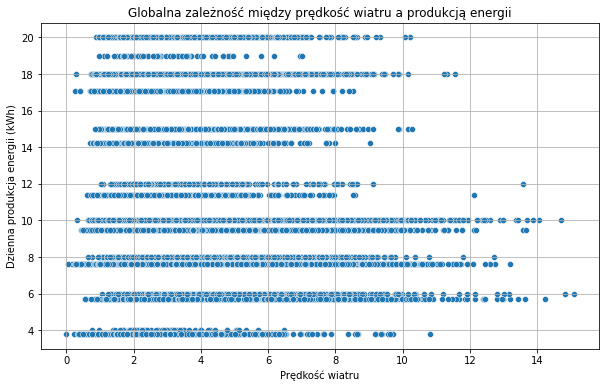

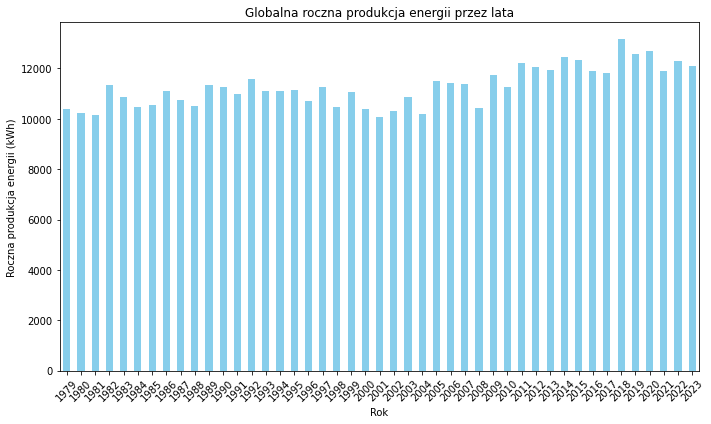

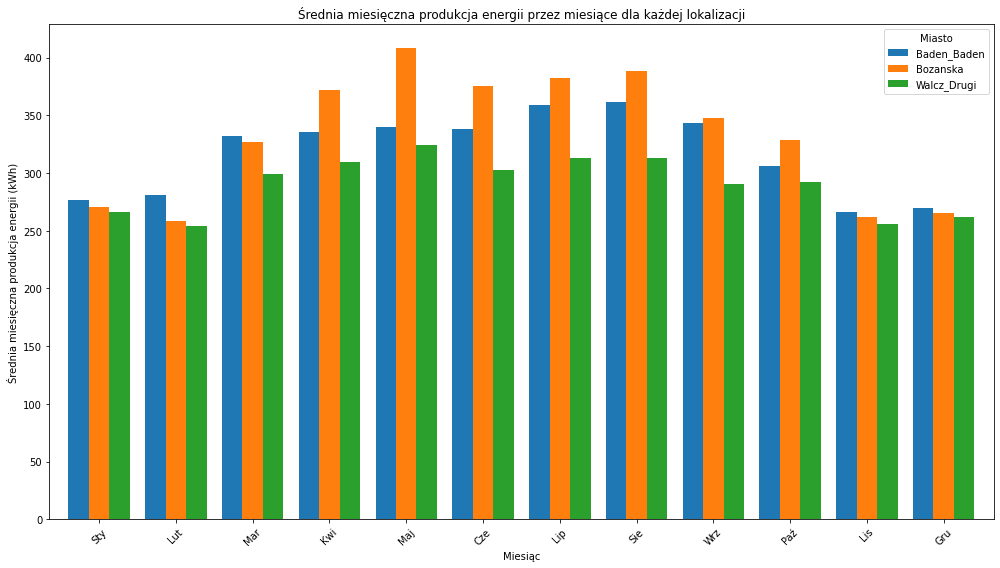

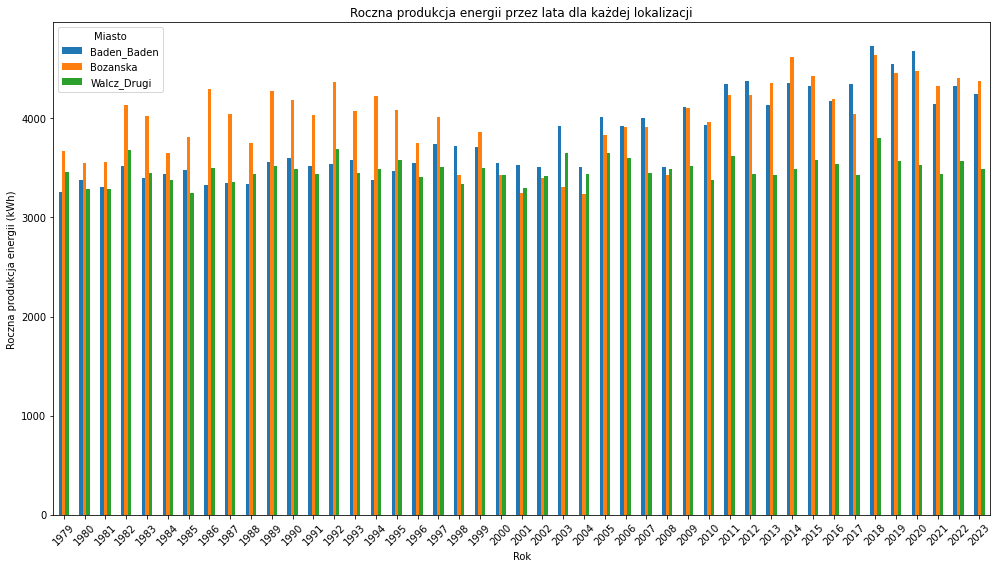

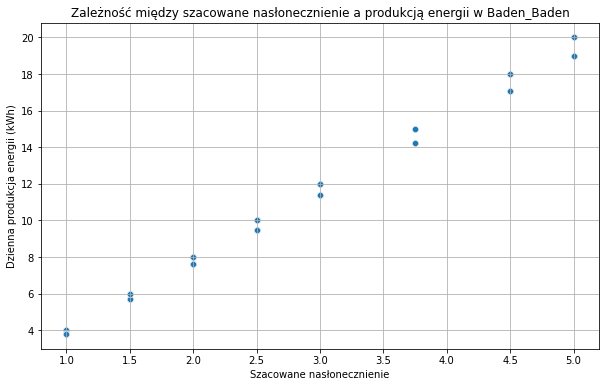

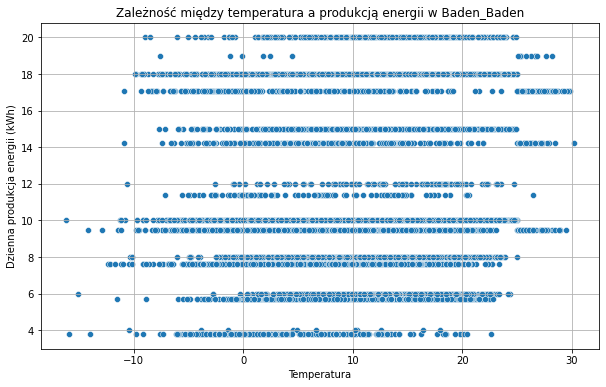

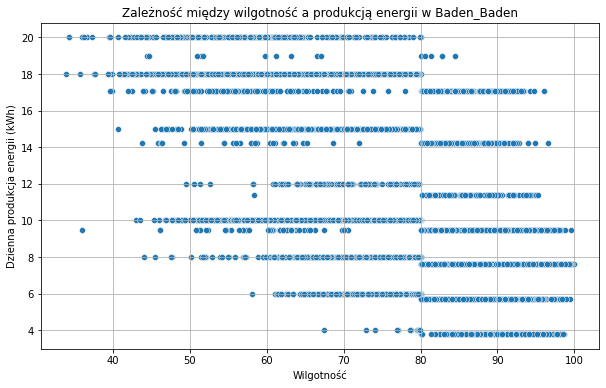

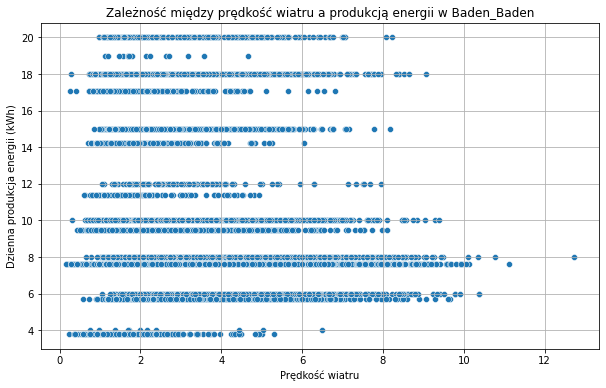

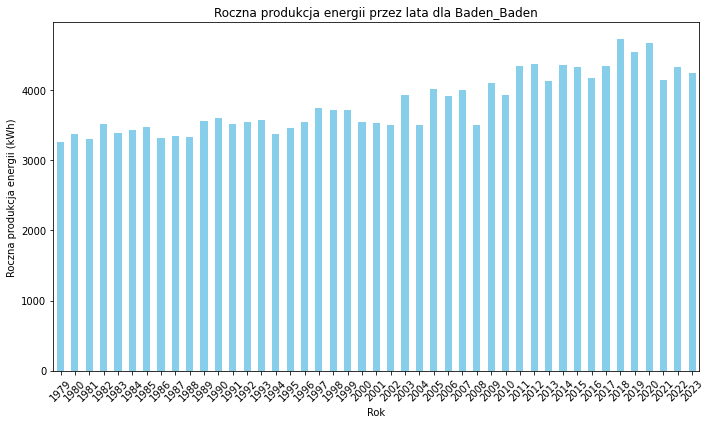

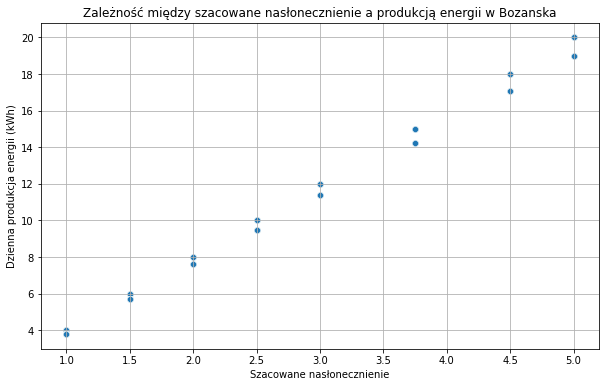

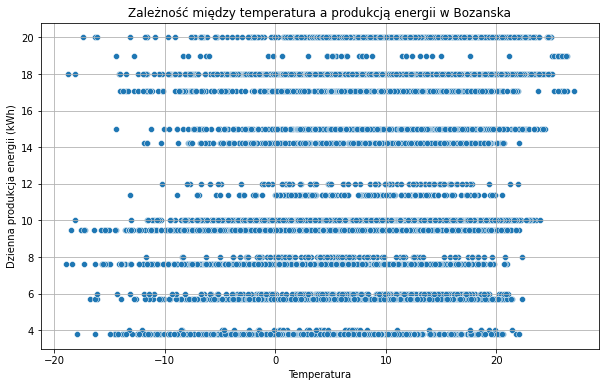

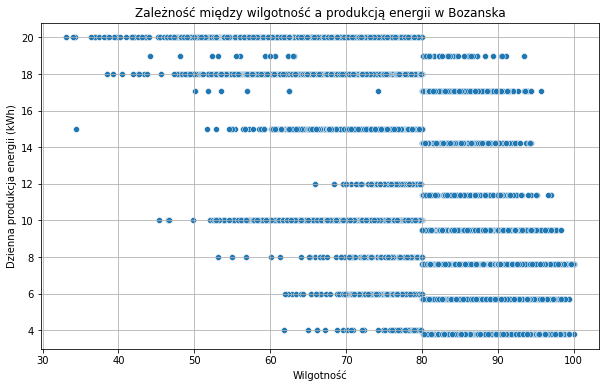

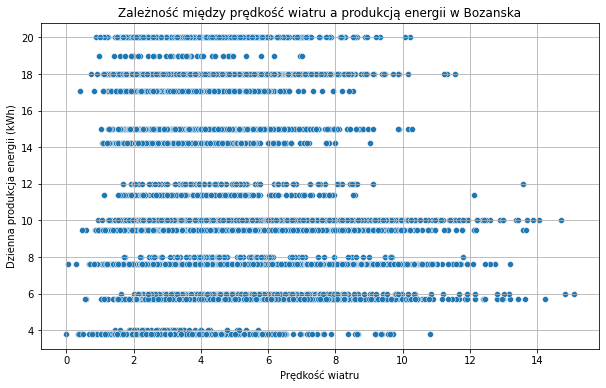

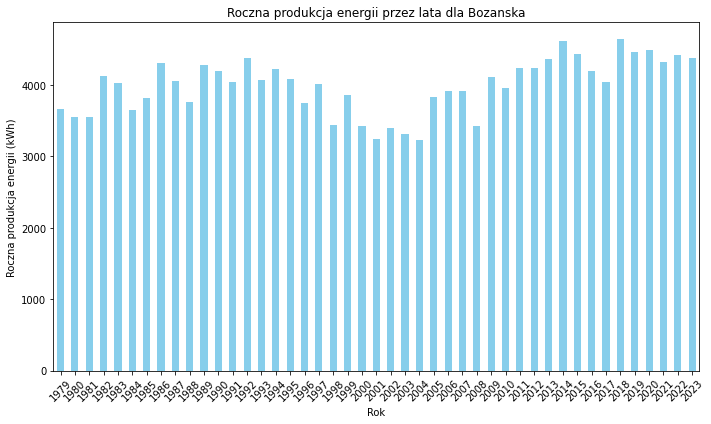

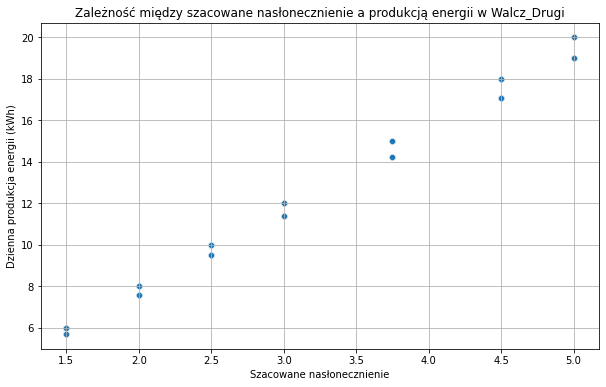

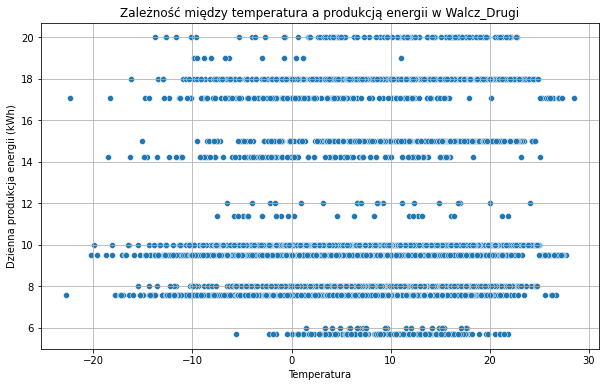

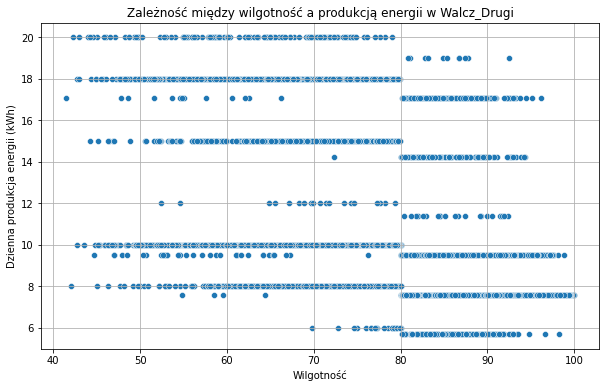

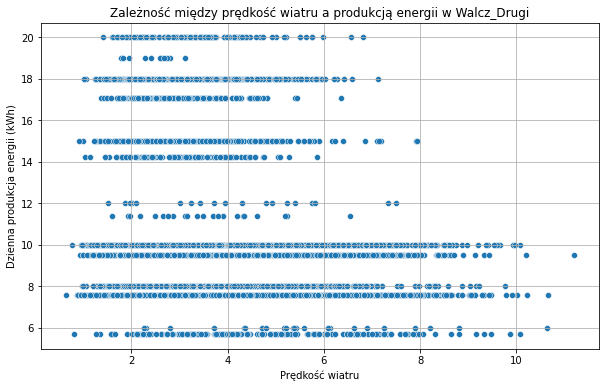

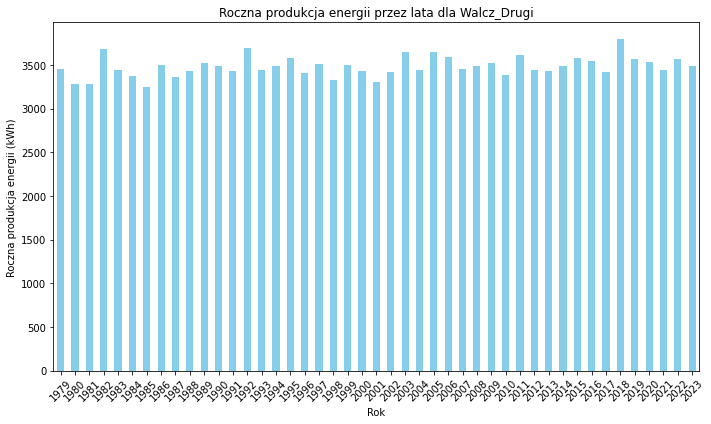

In [36]:
# Konwersja kolumny 'date' do formatu datetime
df_weather_db['date'] = pd.to_datetime(df_weather_db['date'])

# Dodanie kolumn 'year' i 'month' do dalszej analizy
# Konwertujemy kolumnę 'date' na format datetime, aby łatwo można było wyodrębnić rok i miesiąc
df_weather_db['year'] = df_weather_db['date'].dt.year
df_weather_db['month'] = df_weather_db['date'].dt.month

# Definiowanie zmiennych i tytułów do analizy
# Zmienna 'variables' zawiera nazwy kolumn z danymi pogodowymi, które będą analizowane
# Zmienna 'titles' zawiera odpowiednie tytuły do wykresów
variables = ['estimated_irradiance', 'temp', 'humidity', 'wind_speed']
titles = ['Szacowane nasłonecznienie', 'Temperatura', 'Wilgotność', 'Prędkość wiatru']

# Analiza globalna - zależność zmiennych od dziennej produkcji energii
# Tworzymy wykresy rozrzutu dla każdej zmiennej pogodowej w odniesieniu do dziennej produkcji energii
for var, title in zip(variables, titles):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=var, y='daily_energy_production_kWh', data=df_weather_db)
    plt.title(f'Globalna zależność między {title.lower()} a produkcją energii')
    plt.xlabel(title)
    plt.ylabel('Dzienna produkcja energii (kWh)')
    plt.grid(True)
    plt.show()

# Globalne sumy roczne produkcji energii
# Grupujemy dane według roku i sumujemy dzienną produkcję energii, aby uzyskać roczną produkcję energii
global_annual_production = df_weather_db.groupby('year')['daily_energy_production_kWh'].sum()
plt.figure(figsize=(10, 6))
global_annual_production.plot(kind='bar', color='skyblue')
plt.title('Globalna roczna produkcja energii przez lata')
plt.xlabel('Rok')
plt.ylabel('Roczna produkcja energii (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Obliczenie sumy miesięcznej produkcji energii dla każdego roku i lokalizacji
# Grupujemy dane według roku, miesiąca i nazwy miasta, a następnie sumujemy dzienną produkcję energii
grouped_monthly_data = df_weather_db.groupby(['year', 'month', 'city_name'])['daily_energy_production_kWh'].sum().reset_index()

# Obliczenie średniej miesięcznej produkcji energii na przestrzeni lat
# Grupujemy dane według miesiąca i nazwy miasta, a następnie obliczamy średnią miesięczną produkcję energii
average_monthly_energy = grouped_monthly_data.groupby(['month', 'city_name'])['daily_energy_production_kWh'].mean().unstack()

# Tworzenie wykresu dla średniej miesięcznej produkcji energii
# Rysujemy wykres słupkowy przedstawiający średnią miesięczną produkcję energii dla każdej lokalizacji
average_monthly_energy.plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title('Średnia miesięczna produkcja energii przez miesiące dla każdej lokalizacji')
plt.xlabel('Miesiąc')
plt.ylabel('Średnia miesięczna produkcja energii (kWh)')
plt.xticks(ticks=range(0, 12), labels=['Sty', 'Lut', 'Mar', 'Kwi', 'Maj', 'Cze', 'Lip', 'Sie', 'Wrz', 'Paź', 'Lis', 'Gru'], rotation=45)
plt.legend(title='Miasto')
plt.tight_layout()
plt.show()

# Sumy roczne produkcji energii dla każdej lokalizacji na jednym wykresie
# Grupujemy dane według roku i nazwy miasta, a następnie sumujemy dzienną produkcję energii
grouped_annual_data = df_weather_db.groupby(['year', 'city_name'])['daily_energy_production_kWh'].sum().unstack()
grouped_annual_data.plot(kind='bar', figsize=(14, 8))
plt.title('Roczna produkcja energii przez lata dla każdej lokalizacji')
plt.xlabel('Rok')
plt.ylabel('Roczna produkcja energii (kWh)')
plt.xticks(rotation=45)
plt.legend(title='Miasto')
plt.tight_layout()
plt.show()

# Analizy lokalne dla każdej lokalizacji osobno
# Dla każdej lokalizacji tworzymy osobne wykresy analizy zależności zmiennych pogodowych od produkcji energii
for location in df_weather_db['city_name'].unique():
    subset = df_weather_db[df_weather_db['city_name'] == location]
    for var, title in zip(variables, titles):
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=var, y='daily_energy_production_kWh', data=subset)
        plt.title(f'Zależność między {title.lower()} a produkcją energii w {location}')
        plt.xlabel(title)
        plt.ylabel('Dzienna produkcja energii (kWh)')
        plt.grid(True)
        plt.show()

    # Sumy roczne produkcji energii dla każdej lokalizacji
    # Grupujemy dane według roku i sumujemy dzienną produkcję energii dla konkretnej lokalizacji
    local_annual_production = subset.groupby('year')['daily_energy_production_kWh'].sum()
    plt.figure(figsize=(10, 6))
    local_annual_production.plot(kind='bar', color='skyblue')
    plt.title(f'Roczna produkcja energii przez lata dla {location}')
    plt.xlabel('Rok')
    plt.ylabel('Roczna produkcja energii (kWh)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


grouped_monthly_data: Sumuje produkcję energii dla każdego miesiąca, roku i lokalizacji.
average_monthly_energy: Oblicza średnią produkcję dla każdego miesiąca z tych sum, dając rzeczywistą średnią produkcji na przestrzeni lat.

### Wnioski z Analizy Danych

#### Zależność od Nasłonecznienia:
Istnieje silna korelacja między szacowanym nasłonecznieniem a produkcją energii. Dni z większym nasłonecznieniem generują znacząco więcej energii, co jest zgodne z oczekiwaniami dotyczącymi działania paneli fotowoltaicznych.
#### Wpływ Temperatury:
Zależność między temperaturą a produkcją energii nie jest jednoznaczna. Wysokie i niskie temperatury nie wykazują bezpośredniego, spójnego wpływu na ilość produkowanej energii, sugerując, że inne czynniki również odgrywają rolę.
#### Wilgotność i Prędkość Wiatru:
Te czynniki również nie pokazują jednoznacznych wzorców wpływających na produkcję energii. Oznacza to, że ich wpływ na efektywność paneli może być zależny od specyficznych warunków lokalnych lub być mniej znaczący w porównaniu do nasłonecznienia.
#### Analiza Sezonowa i Roczna:
Dane miesięczne wskazują na wyraźne sezonowe wzorce, z wyższą produkcją energii w miesiącach letnich i niższą w zimowych, co odzwierciedla zmiany w nasłonecznieniu związane z porami roku.
#### Analiza roczna ujawnia wahania w produkcji energii z roku na rok, co może odzwierciedlać zmieniające się warunki pogodowe, efektywność instalacji lub ekspansję infrastruktury fotowoltaicznej.
#### Porównania Między Lokalizacjami:
Istnieją zauważalne różnice w ilości produkowanej energii między poszczególnymi lokalizacjami, co może być wynikiem różnic w położeniu geograficznym, lokalnym klimacie lub technologii paneli słonecznych.
### Zastosowanie Wniosków
#### Planowanie i Optymalizacja: Dane te są cenne dla optymalizacji rozmieszczenia i konserwacji paneli fotowoltaicznych, a także dla strategii magazynowania energii, zwłaszcza w okresach sezonowych szczytów i spadków produkcji.
#### Strategiczne Inwestycje: Wnioski z analizy mogą informować o strategicznych decyzjach dotyczących rozbudowy infrastruktury fotowoltaicznej, wyboru lokalizacji dla nowych instalacji oraz potencjalnych modernizacji istniejących systemów.
#### Zarządzanie Energią: Zrozumienie miesięcznych i rocznych wzorców produkcji pozwala lepiej zarządzać popytem na energię, szczególnie w kontekście integracji z innymi źródłami energii i systemami zarządzania energią w smart gridach.
#### Podsumowując, analiza produkcji energii fotowoltaicznej dostarcza kluczowych informacji, które mogą pomóc w efektywniejszym wykorzystaniu zasobów energetycznych i lepszym planowaniu w dziedzinie energetyki odnawialnej.

In [37]:
# Wybór i wyświetlanie pierwszych pięciu wierszy z danymi pogodowymi
df_weather_db.head()

date    city_name        lat        lon       temp  feels_like  \
0 1979-01-01  Baden_Baden  48.765640   8.228524 -10.442083  -16.532917   
1 1979-01-01     Bozanska  54.473028  18.302179 -14.100000  -20.617500   
2 1979-01-01  Walcz_Drugi  53.257039  16.521203 -16.437083  -23.322500   
3 1979-01-02  Baden_Baden  48.765640   8.228524  -8.856667  -14.874167   
4 1979-01-02     Bozanska  54.473028  18.302179  -9.037917  -15.179167   

   temp_min  temp_max     pressure   humidity  wind_speed  clouds_all  \
0    -16.18      3.02  1013.666667  81.916667    3.681667   84.500000   
1    -19.14     -9.46  1002.416667  82.000000    6.157917  100.000000   
2    -21.26     -9.57  1003.708333  82.416667    3.682083   94.791667   
3    -15.82     -3.96  1024.250000  84.208333    4.524583   71.708333   
4    -14.14     -7.40  1004.791667  85.375000    4.449583   99.541667   

  weather_main  estimated_irradiance  temp_modifier  humidity_modifier  \
0       Cloudy                   2.0            1.0               0.95   
1       Cloudy                   2.0            1.0               0.95   
2       Cloudy                   2.0            1.0               0.95   
3         Snow                   1.5            1.0               0.95   
4       Cloudy                   2.0            1.0               0.95   

   daily_energy_production_kWh  year  month  
0                          7.6  1979      1  
1                          7.6  1979      1  
2                          7.6  1979      1  
3                          5.7  1979      1  
4                          7.6  1979      1

In [38]:
#Zapisanie finalenj ramki do dalszej wizualizacji.
df_weather_db.to_csv('../2. Data/processed/final_df_processed.csv')

# TE WNISOKI JESZCZE RAZ SPRAWDZIC Z TYMI U GORY

Na podstawie przeprowadzonych analiz i wygenerowanych wykresów możemy wyciągnąć następujące wnioski dotyczące produkcji energii z paneli fotowoltaicznych:

Zależność od nasłonecznienia: Wyraźnie widoczna jest silna korelacja między szacowanym nasłonecznieniem a produkcją energii. Wyższe nasłonecznienie skutkuje zdecydowanie większą produkcją energii, co potwierdza intuicyjne oczekiwania dotyczące efektywności paneli słonecznych. Dni z pełnym nasłonecznieniem mają znacząco wyższą produkcję energii w porównaniu do dni z niższym nasłonecznieniem.
Wpływ temperatury: Zależność między temperaturą a produkcją energii nie jest tak jednoznaczna jak w przypadku nasłonecznienia. Mimo że ekstremalnie niskie lub wysokie temperatury mogą wpływać na efektywność paneli, nie zaobserwowano silnej korelacji między tymi dwoma zmiennymi na większości wykresów.
Wilgotność i prędkość wiatru: Analiza tych czynników również nie wykazała jednoznacznej zależności z produkcją energii. Choć wysoka wilgotność i prędkość wiatru mogą teoretycznie wpływać na efektywność paneli, dane nie pokazują bezpośredniego wpływu tych zmiennych na produkcję energii na większości wykresów.
Roczne wahania w produkcji energii: Wykresy pokazujące roczne sumy produkcji energii dla różnych lokalizacji ujawniają znaczne wahania z roku na rok. Te zmiany mogą być powiązane ze zmieniającymi się warunkami pogodowymi oraz różnicami w nasłonecznieniu w poszczególnych latach. Pokazuje to, jak bardzo produkcja energii fotowoltaicznej jest zależna od czynników zewnętrznych, które mogą się zmieniać w różnych okresach.
Porównanie lokalizacji: Wyraźne różnice w produkcji energii między lokalizacjami podkreślają znaczenie odpowiedniego wyboru lokalizacji dla instalacji paneli fotowoltaicznych. Niektóre lokalizacje mogą oferować bardziej korzystne warunki dla generowania energii słonecznej z powodu lepszego nasłonecznienia czy innych korzystnych warunków klimatycznych.

Wykres Miesięczny
Pierwszy wykres przedstawia miesięczną produkcję energii dla każdej z lokalizacji, ale sumuje dane za wszystkie lata, dla których dane są dostępne. To oznacza, że każdy słupek dla danego miesiąca i lokalizacji jest sumą całkowitej energii wyprodukowanej w tym miesiącu przez wszystkie lata.

Jak interpretować?

Wykres pokazuje, jak produkcja energii różni się w ciągu roku w zależności od lokalizacji, co pozwala na zrozumienie wzorców sezonowych.
Lokalizacje mogą wykazywać różne poziomy produkcji zależne od ich geograficznego położenia, orientacji instalacji fotowoltaicznych oraz lokalnych warunków meteorologicznych.
Wykres Roczny
Drugi wykres pokazuje roczną produkcję energii dla każdej z lokalizacji, także sumując dane za każdy rok przez cały dostępny okres danych. Na wykresie każdy słupek dla danego roku i lokalizacji reprezentuje sumę energii wyprodukowanej w tym roku.

Jak interpretować?

Wykres pozwala zobaczyć, jak produkcja energii zmieniała się z roku na rok, co może odzwierciedlać zmiany w efektywności paneli, zmiany w warunkach klimatycznych lub inne czynniki wpływające na produkcję energii.
Wzrost lub spadek produkcji w poszczególnych latach może być wynikiem różnych czynników, takich jak rozbudowa instalacji, modernizacje, zmiany w nasłonecznieniu wynikające ze zmian klimatycznych, itp.
Wnioski Ogólne:

Sezonowość i efektywność: Miesięczne wzorce produkcji podkreślają znaczenie sezonowości w planowaniu i wykorzystaniu energii słonecznej.
Trendy roczne i planowanie strategiczne: Zmiany w produkcji rocznej mogą służyć jako wskaźnik dla planowania przyszłych inwestycji, potrzeb konserwacji lub jako dowód na skuteczność wprowadzonych usprawnień.
Optymalizacja: Dane te mogą być użyte do optymalizacji operacji i konserwacji instalacji fotowoltaicznych, planowania magazynowania energii oraz zarządzania popytem na energię.